# Projet 3 : Préparez des données pour un organisme de santé publique

## Contexte

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, qui est open source afin de permettre à tous de connaitre la qualité nutritionnelle des produits.

Aujourd'hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes.

L'agence Santé publique France confie à notre entreprise la création d'un système de suggestion ou d'auto-complétion pour aider les usagers à remplir plus efficacement la base de données, même si cette dernière venait à être légèrement modifiée.


Notre objectif : nettoyer et explorer les données en interne afin de déterminer la faisabilité de cette idée d'application.s. 

## Librairies utilisées avec le langage Python:

In [145]:
# Importation des librairies
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import pyarrow as pya
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import scipy.stats as stats
from scipy.stats import levene
import statsmodels.formula.api as smf
import pingouin as pg 
from pingouin import welch_anova
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

## Visualisation du tableau de données brutes


In [2]:
# Chargement des données brutes du fichier CSV avec des virgules pour séparateur
data=pd.read_csv('fr.openfoodfacts.org.products.csv', delimiter = '\t')
# Visualisation des 5 premières lignes
data.head(5)

code                                                url  \
0   3087  http://world-fr.openfoodfacts.org/produit/0000...   
1   4530  http://world-fr.openfoodfacts.org/produit/0000...   
2   4559  http://world-fr.openfoodfacts.org/produit/0000...   
3  16087  http://world-fr.openfoodfacts.org/produit/0000...   
4  16094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

Les champs sont séparés en quatre sections :

##### Les informations générales sur la fiche du produit :
- code : codebarre du produit ( EAN-13 ou  codes internes pour certains magasins). Pour les produits sans codebarres, Open Food Fact attribue un numéro commençant par le préfixe réservé 200.
- url : url de la page du produit sur Open Food Facts
- creator : contributeur qui a ajouté le produit pour la première fois
- created_t : date à laquelle le produit a été ajouté (timestamp)
- created_datetime : date à laquelle le produit a été ajouté (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- last_modified_t : date à laquelle le produit a été modifié pour la dernière fois (timestamp)
- last_modified_datetime : date à laquelle le produit a été modifié pour la dernière fois (iso8601 format: yyyy-mm-ddThh:mn:ssZ)
- product_name : nom du produit
- generic_name : nom générique
- quantity : quantité et unité

##### Un ensemble de tags (catégorie du produit, origine des ingrédients, liste des pays où il est vendu, ...)

##### Les ingrédients composants les produits et leurs additifs éventuels

##### Des informations nutritionnelles (quantité en gramme d'un nutriment pour 100 grammes du produit)

Pour plus d'informations sur les différentes variables : https://world.openfoodfacts.org/data/data-fields.txt

## Etude des données : nombre de lignes & colonnes, types des données et statistiques

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


Nous avons donc un data frame composé de 162 variables dont 106 sont des type flottant, et 56 de type objet.
Dans ce data frame, 320771 produits ont été entrés.

Interessons nous aux variables avec le plus de valeurs manquantes afin de trouver notre variable cible :

In [4]:
 # Fonction permettant de visualiser le pourcentage de valeurs manquantes par variables et de filtrer sur les variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent

def show_miss_val(data,percent):  
    variables = []
    miss_val = []
    
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    return output[output['miss_val']>=percent].sort_values('miss_val')

In [5]:
#  Appel de la fonction affichant le pourcentage de valeur manquantes par variable avec un filtre de 0.7 pour n'avoir que les colonnes avec plus de 70% de valeurs manquantes
data_vm=show_miss_val(data,0.7)
data_vm.head(120)

variable  miss_val
55         pnns_groups_2  0.705426
54         pnns_groups_1  0.714710
16         categories_fr  0.736850
14            categories  0.736854
15       categories_tags  0.736919
..                   ...       ...
94     elaidic-acid_100g  1.000000
98    nervonic-acid_100g  1.000000
97      erucic-acid_100g  1.000000
52    nutrition_grade_uk  1.000000
161  water-hardness_100g  1.000000

[119 rows x 2 columns]

In [6]:
data['pnns_groups_1'].describe()

count       91513
unique         14
top       unknown
freq        22624
Name: pnns_groups_1, dtype: object

In [7]:
data['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'fruits-and-vegetables',
       'Milk and dairy products', 'Salty snacks', 'sugary-snacks',
       'cereals-and-potatoes', 'salty-snacks'], dtype=object)

La variable 'pnns_groups_1' parait être une bonne variable cible avec 71.5% de valeurs manquantes et seulement 14 valeurs possibles.

## Nettoyage du dataframe

Nous pouvons par contre remarquer que certaines valeurs sont les mêmes et que seules la typographie change. Remédions à cela :

In [8]:
def pnnsgroup1_imputation (data) :
    compt=0
    for item in data['pnns_groups_1'] :
        if item=='salty-snacks' : data.loc[compt,'pnns_groups_1']= 'Salty snacks'
        if item=='cereals-and-potatoes' : data.loc[compt,'pnns_groups_1']= 'Cereals and potatoes'
        if item=='sugary-snacks' : data.loc[compt,'pnns_groups_1']= 'Sugary snacks'
        if item=='fruits-and-vegetables' : data.loc[compt,'pnns_groups_1']= 'Fruits and vegetables'
        compt+=1
    return data

In [9]:
data_1 = pnnsgroup1_imputation (data)
data_1['pnns_groups_1'].unique()

array([nan, 'unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks'], dtype=object)

Nous avons donc maintenant 10 valeurs possibles pour notre variable cible. 

Supprimons ensuite les lignes qui n'ont pas de valeurs pour la variable cible :

In [10]:
#  Fonction supprimant les lignes produits qui ont une valeur manquante pour la variable cible
def supp_nan_cible (data) :
    valeur=['unknown', 'Fruits and vegetables', 'Sugary snacks',
       'Cereals and potatoes', 'Composite foods', 'Fish Meat Eggs',
       'Beverages', 'Fat and sauces', 'Milk and dairy products',
       'Salty snacks']
# Cast de la variable cible comme objet
    data_1['pnns_groups_1']=data['pnns_groups_1'].astype(object)
# Imputation à NaN de toutes les valeurs de 'pnns_groups_1' différentes de celles attendues
    data_1.loc[~data_1['pnns_groups_1'].isin(valeur)]='NaN'
# Suppression des lignes à 'NaN'
    data_1.drop(data_1[data_1['pnns_groups_1'] == 'NaN'].index, inplace=True)
    return data_1

data_2=supp_nan_cible(data_1)
data_pnns_1 =data_2.groupby('pnns_groups_1', dropna=False)['code'].count()
print(data_pnns_1)

pnns_groups_1
Beverages                   9033
Cereals and potatoes        8458
Composite foods             6747
Fat and sauces              5216
Fish Meat Eggs              8041
Fruits and vegetables       6895
Milk and dairy products     8825
Salty snacks                2810
Sugary snacks              12864
unknown                    22624
Name: code, dtype: int64


In [11]:
data_2.shape

(91513, 162)

Il reste 91513 lignes de produits pour poursuivre notre analyse. 

Cherchons maintenant à conserver des variables avec peu de valeurs manquantes et pertinentes pour prédire notre variable cible :

In [12]:
data_vm=show_miss_val(data_2,0)
data_vm.head(50)

variable  miss_val
0                                       code  0.000000
54                             pnns_groups_1  0.000000
55                             pnns_groups_2  0.000000
56                                    states  0.000000
57                               states_tags  0.000000
6                     last_modified_datetime  0.000000
58                                 states_fr  0.000000
3                                  created_t  0.000000
1                                        url  0.000000
5                            last_modified_t  0.000000
4                           created_datetime  0.000011
2                                    creator  0.000022
31                                 countries  0.001661
33                              countries_fr  0.001661
32                            countries_tags  0.001661
7                               product_name  0.032946
12                                    brands  0.041721
13                               brands_tags  0.041754
9                                   quantity  0.110181
60                          main_category_fr  0.110640
59                             main_category  0.110640
15                           categories_tags  0.110640
14                                categories  0.110640
16                             categories_fr  0.110640
11                            packaging_tags  0.194726
10                                 packaging  0.194759
34                          ingredients_text  0.232885
46               ingredients_from_palm_oil_n  0.232885
49   ingredients_that_may_be_from_palm_oil_n  0.232885
42                               additives_n  0.232885
43                                 additives  0.233202
63                               energy_100g  0.259001
112                            proteins_100g  0.266279
65                                  fat_100g  0.296439
101                       carbohydrates_100g  0.301345
116                                salt_100g  0.302055
117                              sodium_100g  0.302143
102                              sugars_100g  0.304929
66                        saturated-fat_100g  0.308262
62                           image_small_url  0.308754
61                                 image_url  0.308754
53                        nutrition_grade_fr  0.324642
159                  nutrition-score-uk_100g  0.324642
158                  nutrition-score-fr_100g  0.324642
29                           purchase_places  0.386065
8                               generic_name  0.439446
30                                    stores  0.452154
23                                 labels_fr  0.539169
22                               labels_tags  0.539169
21                                    labels  0.540109

Voici les variables qu'il semble pertinent de garder pour notre analyse et la prédiction de notre variable cible : pnns_groups_1, pnns_groups_2, product_name, main_category_fr, energy_100g, proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,sugars_100g,saturated-fat_100g,nutrition_grade_fr, nutrition-score-fr_100g	

In [13]:
#  Fonction permettant de ne garder que les variables d'intérêt définies au préalable
def sel_var_interet (data) :
    variable =['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']
    del_var=[]
    for var in data.columns :
        if var not in variable : del_var.append(var)
    data=data.drop(del_var,axis=1)
    return data
    

In [14]:
data_3 = sel_var_interet(data_2)

In [105]:
data_3.head(10)

product_name nutrition_grade_fr          pnns_groups_1  \
46                    Filet de bœuf                NaN                unknown   
106                  Lion Peanut x2                  e                unknown   
136                         Twix x2                NaN                unknown   
138                  Pack de 2 Twix                NaN                unknown   
174                    Salade Cesar                  c  Fruits and vegetables   
175  Danoises à la cannelle roulées                NaN          Sugary snacks   
177                           Flute                NaN   Cereals and potatoes   
180    Chaussons tressés aux pommes                  c          Sugary snacks   
181             Pain Burger Artisan                  b                unknown   
182               lentilles vertes                 NaN   Cereals and potatoes   

          pnns_groups_2                         main_category_fr energy_100g  \
46              unknown                           Filet-de-boeuf         NaN   
106             unknown                                      NaN      1883.0   
136             unknown                                      NaN         NaN   
138             unknown                                      NaN      1481.0   
174          Vegetables                            Légumes frais      1210.0   
175  Biscuits and cakes                              Pâtisseries      1520.0   
177               Bread                                    Pains         NaN   
180  Biscuits and cakes                              Pâtisseries      1090.0   
181             unknown                                 Boulange      1160.0   
182             Legumes  Aliments et boissons à base de végétaux         NaN   

    fat_100g saturated-fat_100g monounsaturated-fat_100g  \
46       NaN                NaN                      NaN   
106     20.0               12.5                      NaN   
136      NaN                NaN                      NaN   
138     4.17                NaN                      NaN   
174     12.0                7.0                      NaN   
175     14.4                NaN                      NaN   
177      NaN                NaN                      NaN   
180     10.7                2.0                     3.33   
181     1.11              0.333                      NaN   
182      NaN                NaN                      NaN   

    polyunsaturated-fat_100g trans-fat_100g carbohydrates_100g sugars_100g  \
46                       NaN            NaN                NaN         NaN   
106                      NaN            NaN               70.0        57.5   
136                      NaN            NaN                NaN         NaN   
138                      NaN            NaN              77.08         NaN   
174                      NaN            NaN               23.0         0.0   
175                      NaN            NaN               54.1        28.1   
177                      NaN            NaN                NaN         NaN   
180                     5.33          0.667               38.7        24.7   
181                      NaN            0.0               53.3        1.11   
182                      NaN            NaN                NaN         NaN   

    proteins_100g salt_100g sodium_100g nutrition-score-fr_100g  
46            NaN       NaN         NaN                     NaN  
106           2.5   0.09652       0.038                    22.0  
136           NaN       NaN         NaN                     NaN  
138          6.25       NaN         NaN                     NaN  
174          22.0      2.16        0.85                     6.0  
175          4.79     0.922       0.363                     NaN  
177           NaN       NaN         NaN                     NaN  
180          3.33     0.647       0.255                     9.0  
181          10.0      1.52         0.6                     1.0  
182           NaN       NaN         NaN                     NaN

Recherchons maintenant les doublons. Nous considèrerons que les doublons sont les lignes identiques pour la totalité des 17 variables d'intérêt choisies.

In [16]:
data_3.duplicated(subset=['pnns_groups_1', 'pnns_groups_2', 'product_name', 'main_category_fr', 'energy_100g', 'proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g',
               'sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','nutrition_grade_fr', 'nutrition-score-fr_100g']).sum()


5246

Il existe 5246 duplicatas. Supprimons les :

In [17]:
data_4 = data_3.drop_duplicates()
data_4.shape

(86267, 17)

Il nous reste un dataframe de 86267 lignes ou produits avec 17 variables pour notre analyse. Regardons le de plus près :

In [18]:
# data_4.dtypes

Castons les variables finissant par _100g comme flottant puisque ce sont des variables quantitatives :

In [19]:
# data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']].apply(pd.to_numeric)


In [61]:
# data_4.dtypes

product_name                object
nutrition_grade_fr          object
pnns_groups_1               object
pnns_groups_2               object
main_category_fr            object
energy_100g                 object
fat_100g                    object
saturated-fat_100g          object
monounsaturated-fat_100g    object
polyunsaturated-fat_100g    object
trans-fat_100g              object
carbohydrates_100g          object
sugars_100g                 object
proteins_100g               object
salt_100g                   object
sodium_100g                 object
nutrition-score-fr_100g     object
dtype: object

In [21]:
#  Variables quantitatives :
data_4.describe()

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  energy_100g  fat_100g  saturated-fat_100g  \
count             78023      66693.0   63275.0             62258.0   
unique             3543       3792.0    1527.0              1299.0   
top            Boissons          0.0       0.0                 0.0   
freq               3031        344.0    5249.0              8270.0   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count                     2107.0                    2131.0          1865.0   
unique                     477.0                     433.0            74.0   
top                          0.0                       0.0             0.0   
freq                        75.0                      71.0          1613.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
count              62829.0      62557.0        66033.0    62814.0   
unique              1794.0       1640.0         1277.0     3073.0   
top                    0.0          0.0            0.0        0.0   
freq                2701.0       4386.0         4189.0     5376.0   

        sodium_100g  nutrition-score-fr_100g  
count       62806.0                  60766.0  
unique       2931.0                     53.0  
top             0.0                      0.0  
freq         5372.0                   3251.0

In [22]:
#  Variables qualitatives :
data_4.describe(exclude=[np.number])

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  energy_100g  fat_100g  saturated-fat_100g  \
count             78023      66693.0   63275.0             62258.0   
unique             3543       3792.0    1527.0              1299.0   
top            Boissons          0.0       0.0                 0.0   
freq               3031        344.0    5249.0              8270.0   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count                     2107.0                    2131.0          1865.0   
unique                     477.0                     433.0            74.0   
top                          0.0                       0.0             0.0   
freq                        75.0                      71.0          1613.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
count              62829.0      62557.0        66033.0    62814.0   
unique              1794.0       1640.0         1277.0     3073.0   
top                    0.0          0.0            0.0        0.0   
freq                2701.0       4386.0         4189.0     5376.0   

        sodium_100g  nutrition-score-fr_100g  
count       62806.0                  60766.0  
unique       2931.0                     53.0  
top             0.0                      0.0  
freq         5372.0                   3251.0

Nous pouvons observer des valeurs aberrantes pour les variables quantitatives. Toutes les variables qui finissent par '_100g' sont exprimés en g (excepté pour l'energie, en KJ, et le nutriscore) et ne peuvent donc pas dépasser 100g dans 100g de produit. Les valeurs de ces variables ne peuvent pas non plus être négatives.

Excepté pour l'energie et le nutriscore, imputons en Nan toutes les valeurs négatives ou supérieures à 100 pour les variables finissant par '_100g'.

Concernant l'énergie, après des recherches, il semblerait que l'énergie maximum en kJ pour 100g est d'environ 3800kJ. Il semble pertinent d'imputer en Nan les valeurs de cette variable qui sont supérieures à 4000kJ.

In [23]:
# Fonction permettant de ne garder que les variables quantitatives du Dataframe
def col_quant (data) :
    del_var=[]
    variables = data.columns
    for item in variables :
        if data[item].dtypes == 'object' :
            del_var.append(item)
    output = data.drop(columns=del_var, axis = 1)
    return output

# Imputation des valeur aberrantes en Nan
def imput_nan_imp_values_100gcol(data) :
    variables = ['energy_100g','energy-kj_100g','energy-kcal_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
    data_quant=col_quant(data)
    df=data_quant.columns
    for item in df :
        if item =='energy_100g' :
            data.loc[(data[item]>4000), item]= np.nan
        elif item not in variables :
            data.loc[(data[item]<0) |(data[item]>100), item]= np.nan
        else : pass
    return data

In [24]:
data_clean=imput_nan_imp_values_100gcol(data_4)

# Nouvelles statistiques des colonnes quantitatives sans les valeurs aberrantes
data_clean.describe()

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  energy_100g  fat_100g  saturated-fat_100g  \
count             78023      66693.0   63275.0             62258.0   
unique             3543       3792.0    1527.0              1299.0   
top            Boissons          0.0       0.0                 0.0   
freq               3031        344.0    5249.0              8270.0   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count                     2107.0                    2131.0          1865.0   
unique                     477.0                     433.0            74.0   
top                          0.0                       0.0             0.0   
freq                        75.0                      71.0          1613.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
count              62829.0      62557.0        66033.0    62814.0   
unique              1794.0       1640.0         1277.0     3073.0   
top                    0.0          0.0            0.0        0.0   
freq                2701.0       4386.0         4189.0     5376.0   

        sodium_100g  nutrition-score-fr_100g  
count       62806.0                  60766.0  
unique       2931.0                     53.0  
top             0.0                      0.0  
freq         5372.0                   3251.0

Pour un souci de facilité, automatisons cette première étape de nettoyage avant d'approfondir l'analyse :

In [65]:
#  Fonction automatisant le nettoyage du dataframe en utilisant les fonctions développées précédemment
def nettoyage_df (data) :
    data_1 = pnnsgroup1_imputation (data)
    data_2=supp_nan_cible(data_1)
    data_3 = sel_var_interet(data_2)
    data_4 = data_3.drop_duplicates(ignore_index=True)
    # data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']]=data_4[['nutrition-score-fr_100g','energy_100g','proteins_100g','fat_100g','carbohydrates_100g','salt_100g','sodium_100g','sugars_100g','saturated-fat_100g','trans-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g']].apply(pd.to_numeric)
    data_clean=imput_nan_imp_values_100gcol(data_4)
    return data_clean

In [88]:
data_clean = nettoyage_df(data)
data_clean.describe()

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  energy_100g  fat_100g  saturated-fat_100g  \
count             78023      66693.0   63275.0             62258.0   
unique             3543       3792.0    1527.0              1299.0   
top            Boissons          0.0       0.0                 0.0   
freq               3031        344.0    5249.0              8270.0   

        monounsaturated-fat_100g  polyunsaturated-fat_100g  trans-fat_100g  \
count                     2107.0                    2131.0          1865.0   
unique                     477.0                     433.0            74.0   
top                          0.0                       0.0             0.0   
freq                        75.0                      71.0          1613.0   

        carbohydrates_100g  sugars_100g  proteins_100g  salt_100g  \
count              62829.0      62557.0        66033.0    62814.0   
unique              1794.0       1640.0         1277.0     3073.0   
top                    0.0          0.0            0.0        0.0   
freq                2701.0       4386.0         4189.0     5376.0   

        sodium_100g  nutrition-score-fr_100g  
count       62806.0                  60766.0  
unique       2931.0                     53.0  
top             0.0                      0.0  
freq         5372.0                   3251.0

In [27]:
data_clean.describe(exclude=[np.number])  

product_name nutrition_grade_fr pnns_groups_1 pnns_groups_2  \
count         85309              60766         86267         86267   
unique        72123                  5            10            40   
top          Orange                  d       unknown       unknown   
freq             43              16578         20116         20116   

       main_category_fr  
count             78023  
unique             3543  
top            Boissons  
freq               3031

In [28]:
data_clean.shape

(86267, 17)

## Analyses et visualisations

Regardons la distribution des variables catégorielles :

<Axes: title={'center': 'Répartition du nutriscore dans notre dataframe nettoyé.'}, xlabel='nutrition_grade_fr', ylabel='count'>

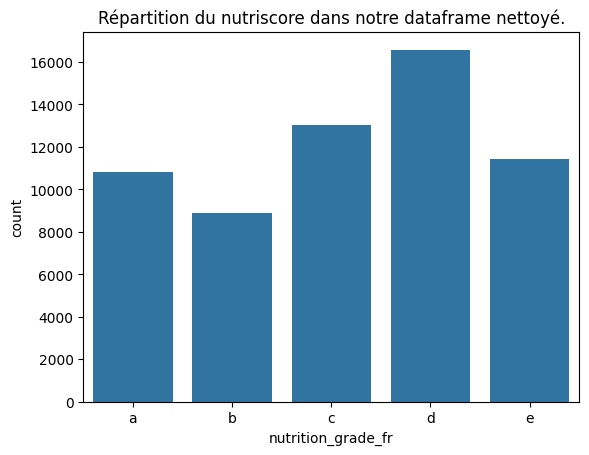

In [29]:
plt.title(f'Répartition du nutriscore dans notre dataframe nettoyé.')
sns.countplot(data_clean, x="nutrition_grade_fr", order=['a','b','c','d','e'])

In [30]:
# Calcul de la répartition du nutriscore
data_nutri =data_clean.groupby('nutrition_grade_fr', dropna=False)['pnns_groups_1'].count()
print(data_nutri)

nutrition_grade_fr
a      10829
b       8880
c      13044
d      16578
e      11435
NaN    25501
Name: pnns_groups_1, dtype: int64


Text(0.5, 1.0, 'Proportion des nutriscores')

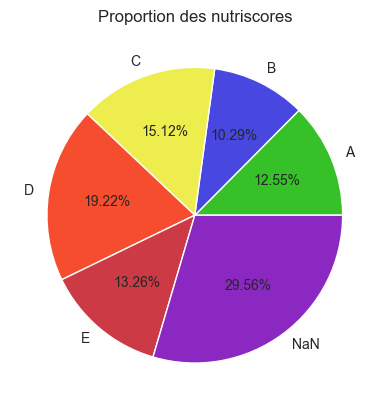

In [31]:
labels = ['A', 'B', 'C', 'D', 'E','NaN']
colors = ['#36c128','#4848E1','#EDED4E','#F64D2F','#CC3B45','#8b28c1']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")

Il y a un nombre non négligeable (presque 30%) de valeurs de nutrigrade manquants. Regardons si un nutriscore est renseigné afin de pouvoir l'imputer :

In [32]:
nutriscore_mv=data_clean.loc[(data_clean['nutrition-score-fr_100g'].isna()==False) & (data_clean['nutrition_grade_fr']=='Nan')]
nutriscore_mv.shape

(0, 17)

Aucun nutriscore n'est renseigné pour un nutrigrade manquant. L'imputation n'est donc pas évidente.

In [33]:
# Création d'une liste ordonné de 'pnns_groups_1' en fonction du plus grand nombre de nutriscore 'a'
nutriscore_order = data_clean.groupby('pnns_groups_1',as_index=False)['nutrition_grade_fr'].value_counts()
nutriscore_order=nutriscore_order.loc[(nutriscore_order['nutrition_grade_fr']=='a'), ['pnns_groups_1','count']]
nutriscore_order=nutriscore_order.sort_values(by="count", ascending=False)

<Axes: title={'center': 'Nombre de produits par catégorie et nutriscore'}, xlabel='count', ylabel='pnns_groups_1'>

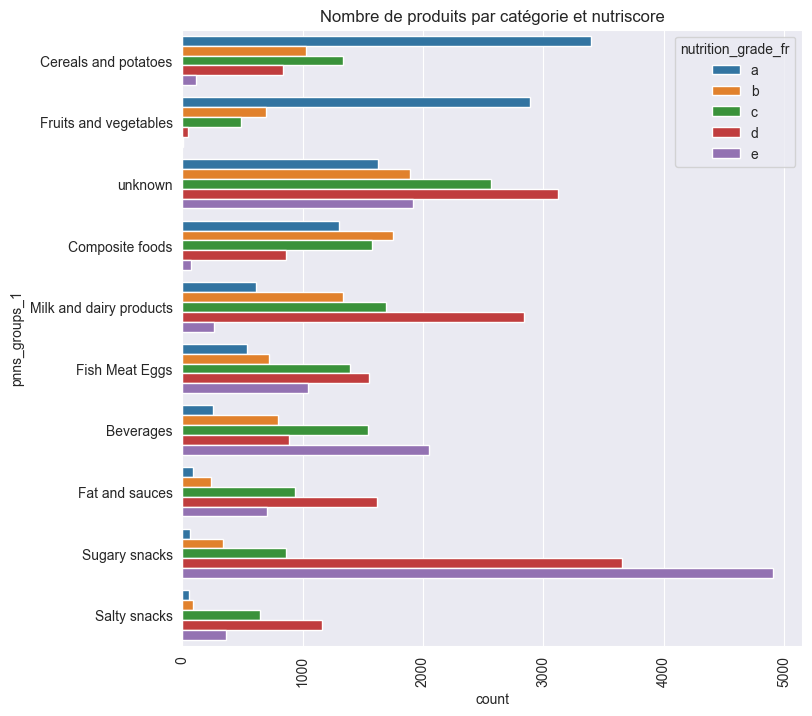

In [34]:
plt.figure(figsize=(8, 8))
plt.xticks(rotation = 'vertical')
plt.title(f'Nombre de produits par catégorie et nutriscore')
sns.countplot(data_clean, y="pnns_groups_1",hue="nutrition_grade_fr",hue_order=['a','b','c','d','e'], order=nutriscore_order['pnns_groups_1'])

Sans surprise, on aperçoit que les catégories avec le moins de produits avec de bons nutriscores sont les catégories salées, sucrées, graisses,...

Passons aux variables quantitatives :

(on affichera pas les valeurs atypiques sur les boîtes à moustaches car les distributions des variables ne sont pas normales et donc la méthode interquartile n'est pas pertinente pour détecter les valeurs atypiques)

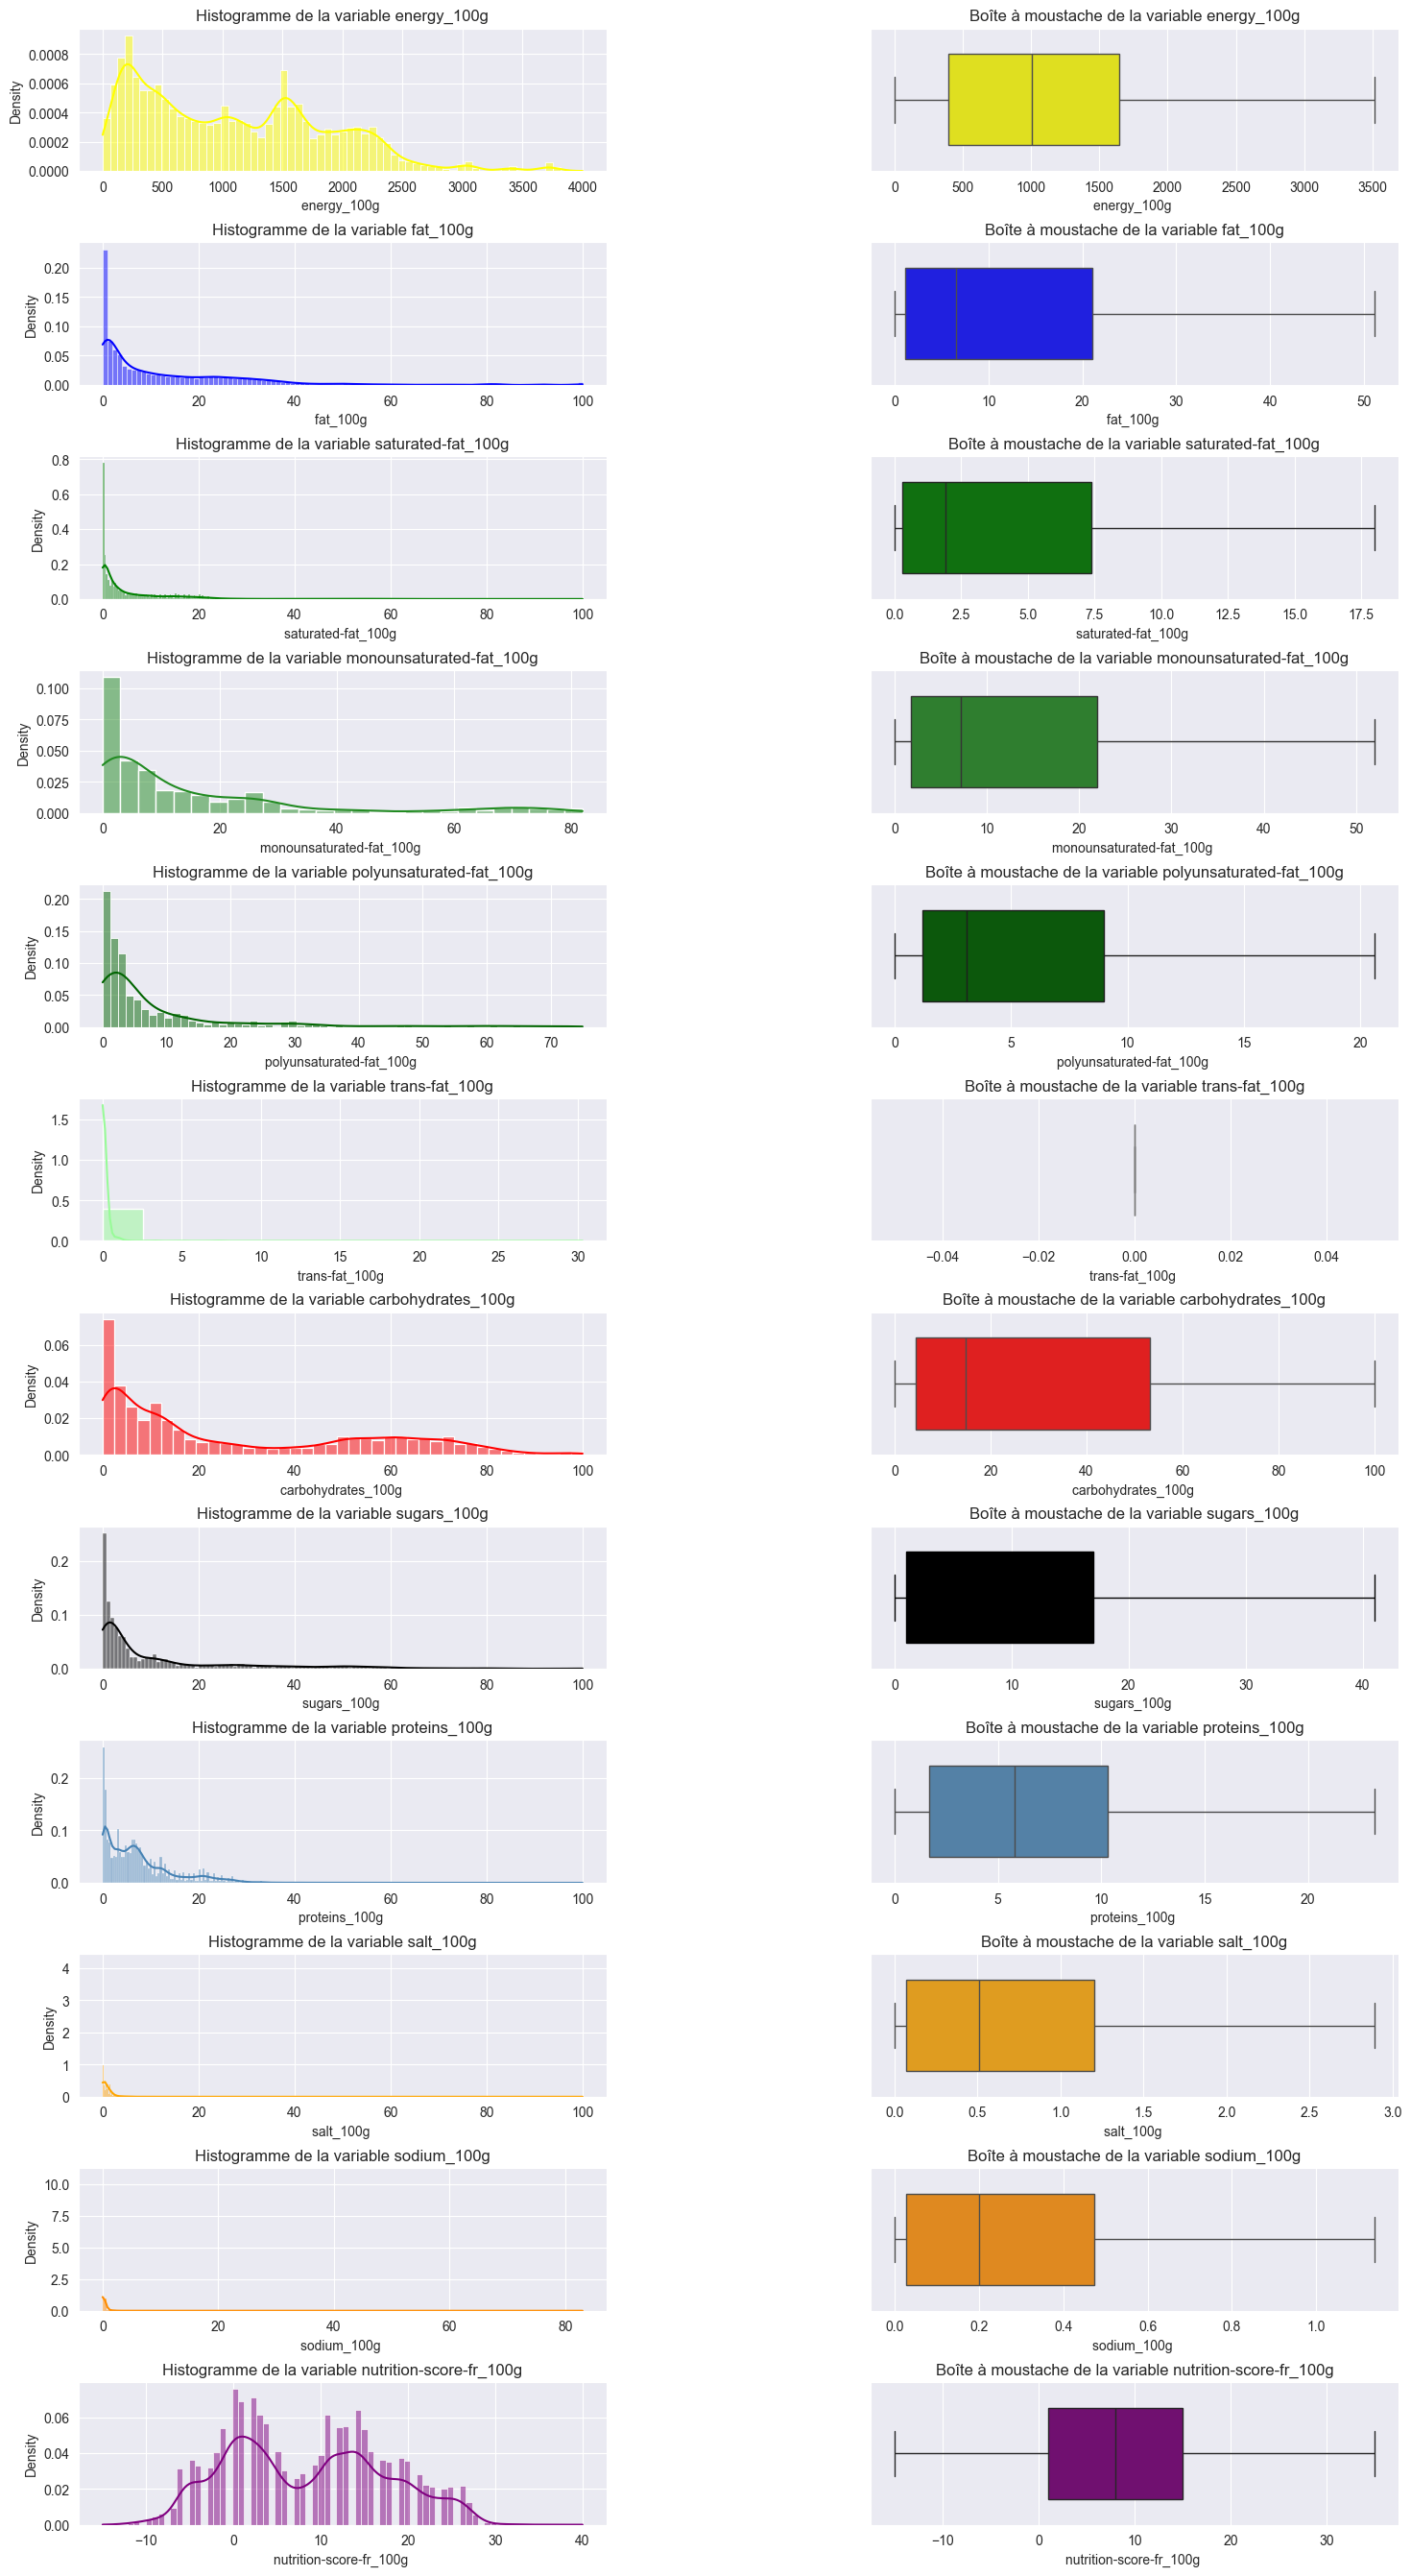

In [35]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('monounsaturated-fat_100g','forestgreen',7),('polyunsaturated-fat_100g','darkgreen',9),('trans-fat_100g','palegreen',11),('carbohydrates_100g','red',13),('sugars_100g','black',15),('proteins_100g','steelblue',17),('salt_100g','orange',19),('sodium_100g','darkorange',21),('nutrition-score-fr_100g','purple',23)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(12, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density")
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(12, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Visualisons les également à l'échelle logarithmique pour mieux visualiser la distribution :

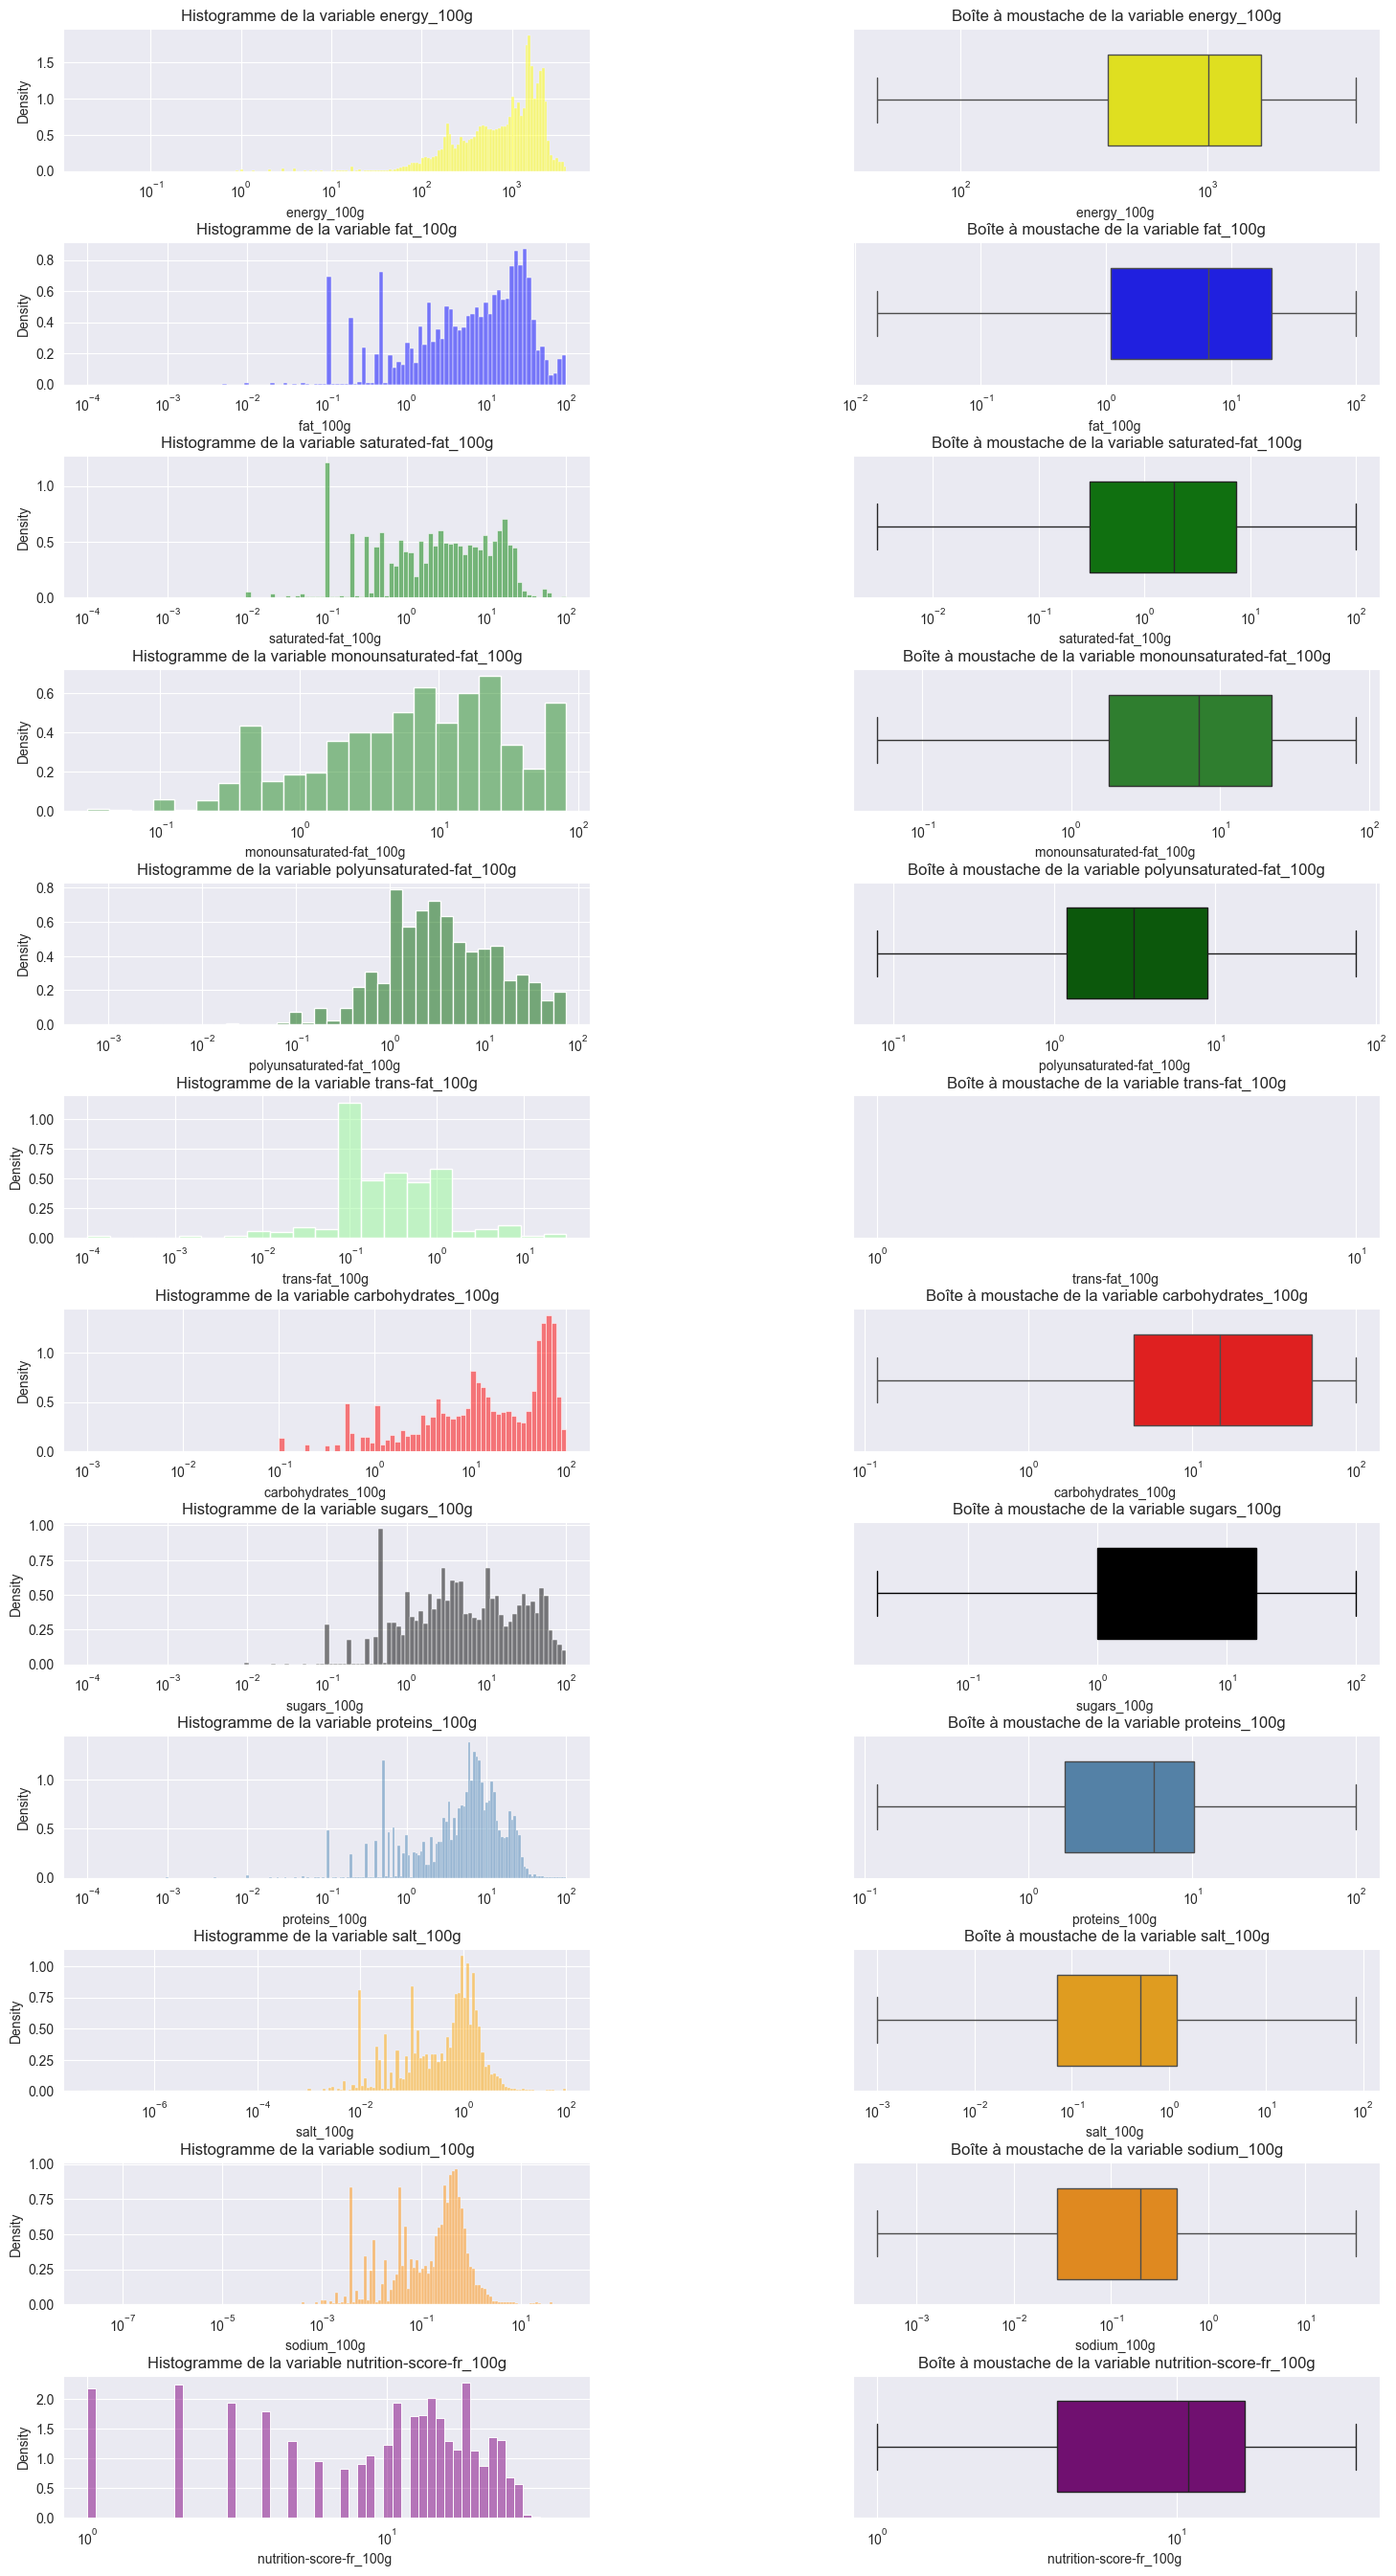

In [36]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',3),('saturated-fat_100g','green',5),('monounsaturated-fat_100g','forestgreen',7),('polyunsaturated-fat_100g','darkgreen',9),('trans-fat_100g','palegreen',11),('carbohydrates_100g','red',13),('sugars_100g','black',15),('proteins_100g','steelblue',17),('salt_100g','orange',19),('sodium_100g','darkorange',21),('nutrition-score-fr_100g','purple',23)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 20))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(12, 2, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

    place=place+1
    # Création des boîtes à moustaches
    axes = figure.add_subplot(12, 2, place)
    sns.boxplot(data=data_clean,x=variable, ax=axes,gap=0.2,legend=False, color=color, showfliers=False, log_scale=True)
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")


Passons à des analyses bivariées sur ces données et construisons maintenant la matrice de corrélations pour définir des relations entre les variables :

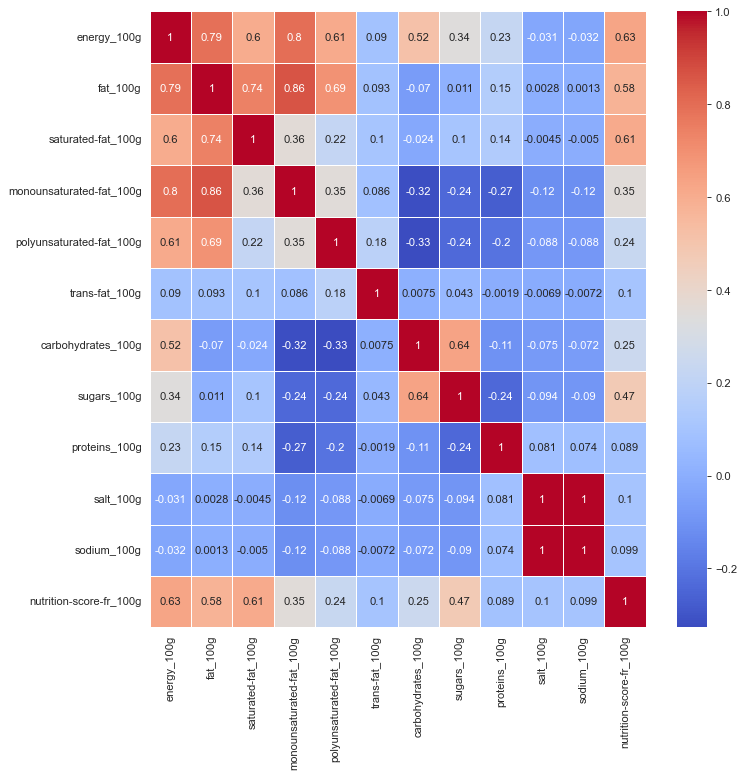

In [37]:
data_quant=col_quant(data_clean)
corr=data_quant.corr()
fig = plt.figure(figsize=(10,10), dpi = 80)
sns.heatmap(corr,cmap='coolwarm',annot=True,linewidth=0.9)
plt.show()

Nous observons :
 - une corrélation parfaite entre le sel et le sodium qui était attendue, l'analyse d'une seule de ces variables sera pertinente
 - les graisses sont fortement corrélées entre elles (excepté la trans-fat) et également corrélées au nutriscore et à l'énergie
 - le sucre et les carbohydrates sont fortement corrélés entre eux
 - le sucre est légèrement corrélé au nutriscore et les carbohydrates à l'énergie
 - Aucune anti-corrélation prononcée n'apparait

Si nous nous concentrons uniquement sur ces variables :

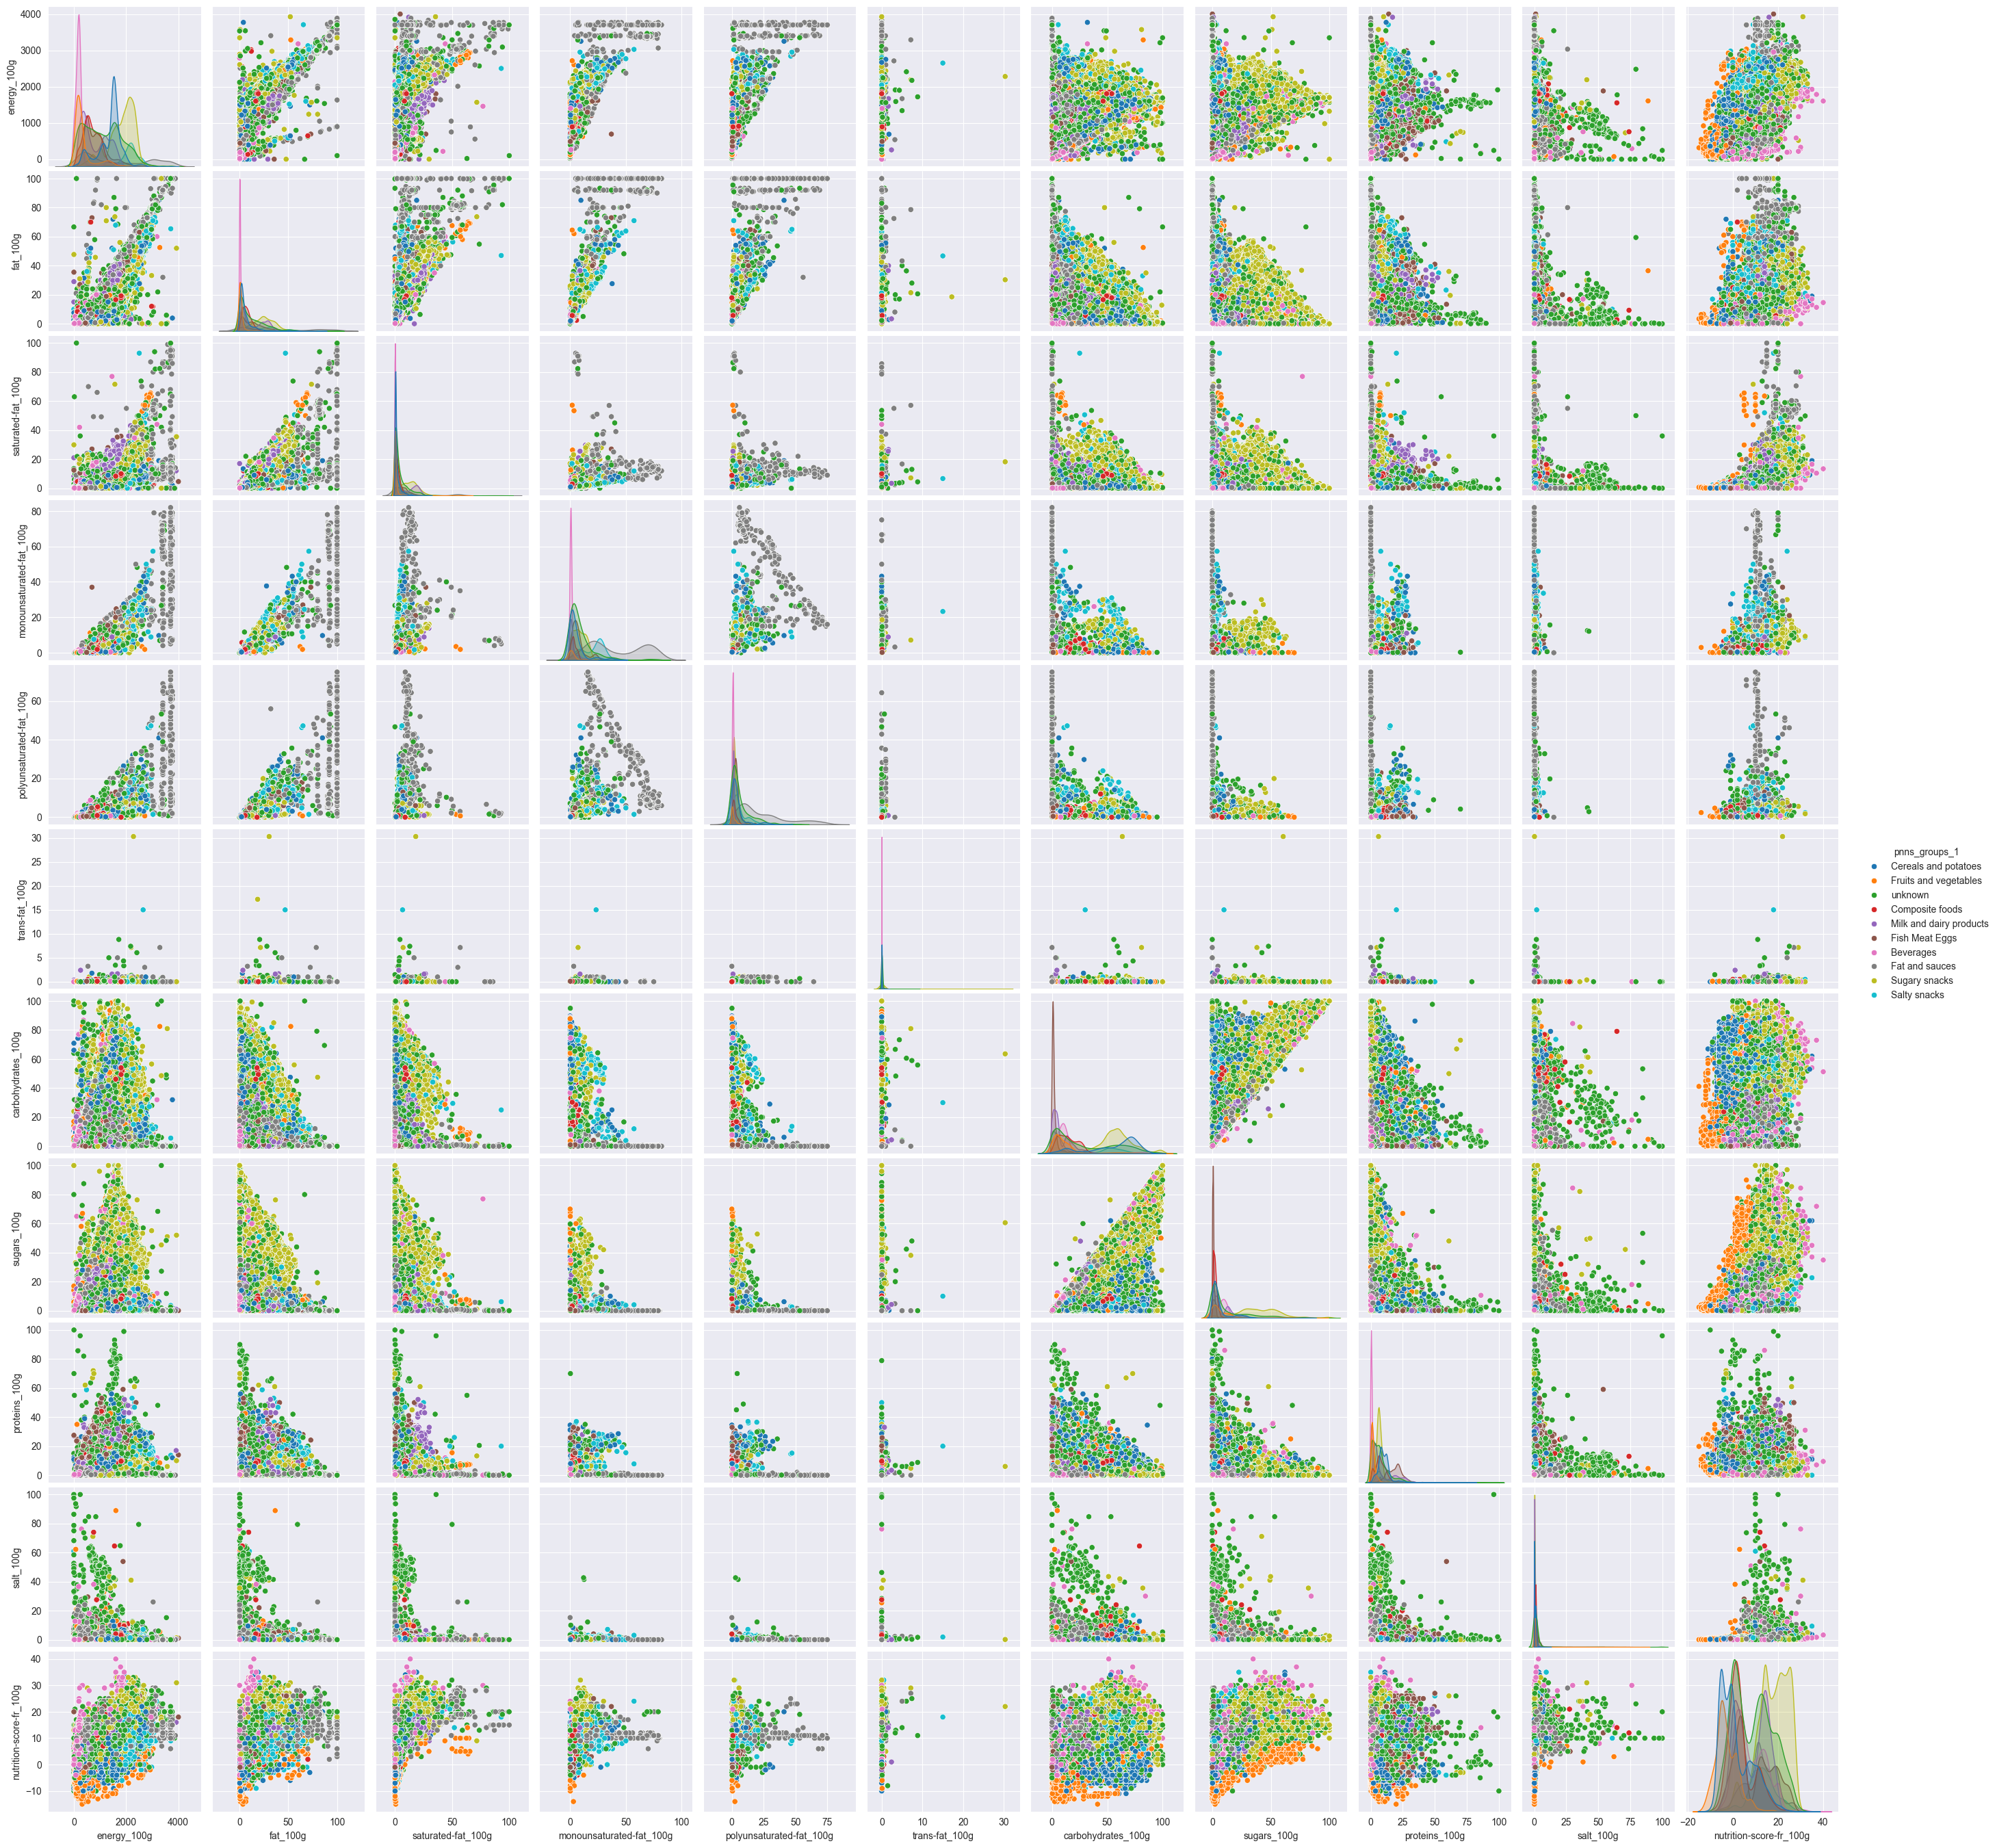

<Figure size 2942.88x2750 with 0 Axes>

In [38]:
variable=['energy_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','trans-fat_100g','carbohydrates_100g','sugars_100g','proteins_100g','salt_100g','nutrition-score-fr_100g','pnns_groups_1']
hue_order =nutriscore_order['pnns_groups_1']
data_quant_corr = data_clean[variable]
# Analyse mutivariée via la méthode pairplot
sns_plot = sns.pairplot(data_quant_corr, hue="pnns_groups_1",hue_order=hue_order)
sns_plot.savefig("pairplot.png")
plt.clf() # Clean pairplot figure
Image(filename='pairplot.png') # Création de l'image PNG

On retrouve les résultats de la matrice de corrélations.

En les traçant en fonction du pnns_groups_1, on voit que les légumes sont plus facilement localisés sur un nutriscore bas ainsi que des valeurs basses de sel, sucre, graisses...

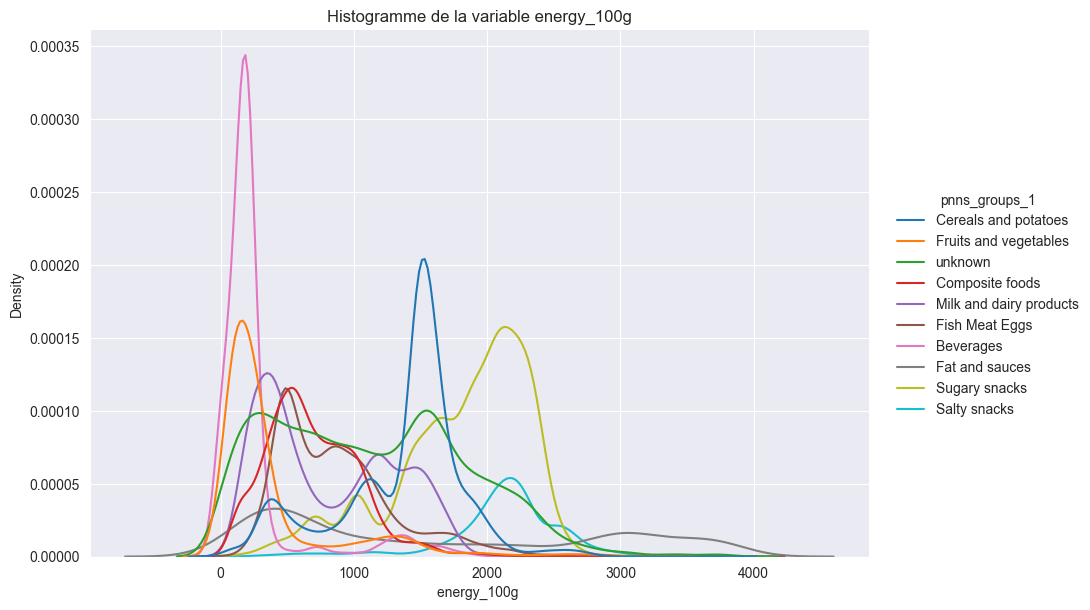

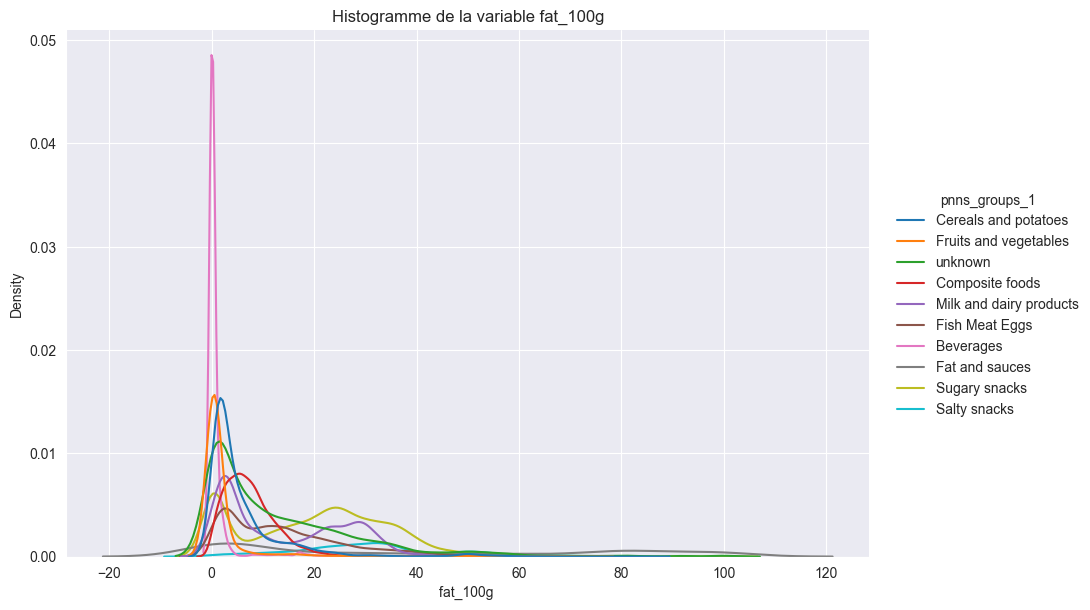

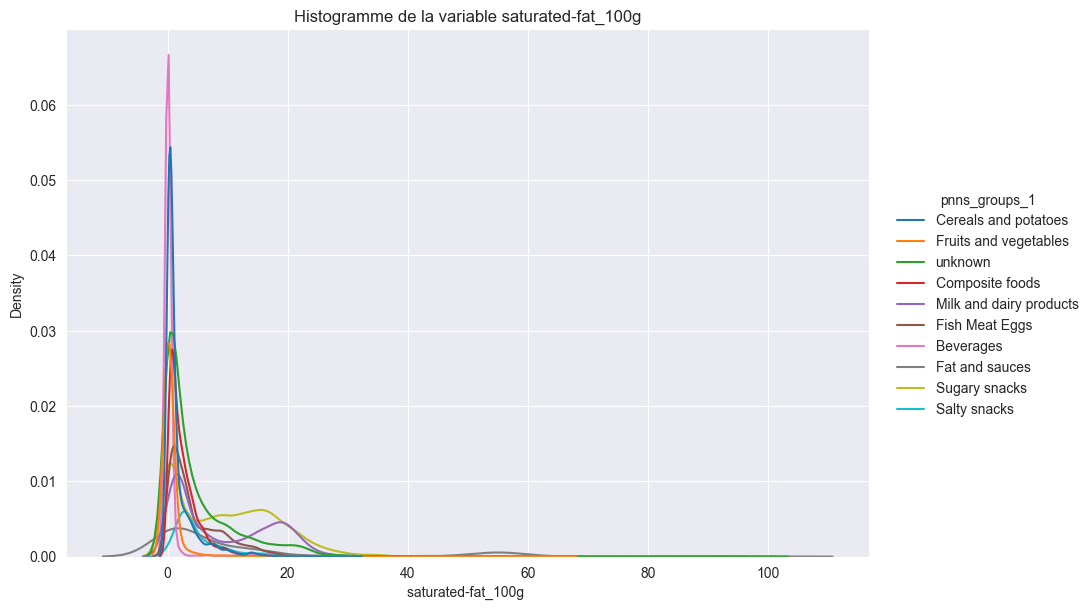

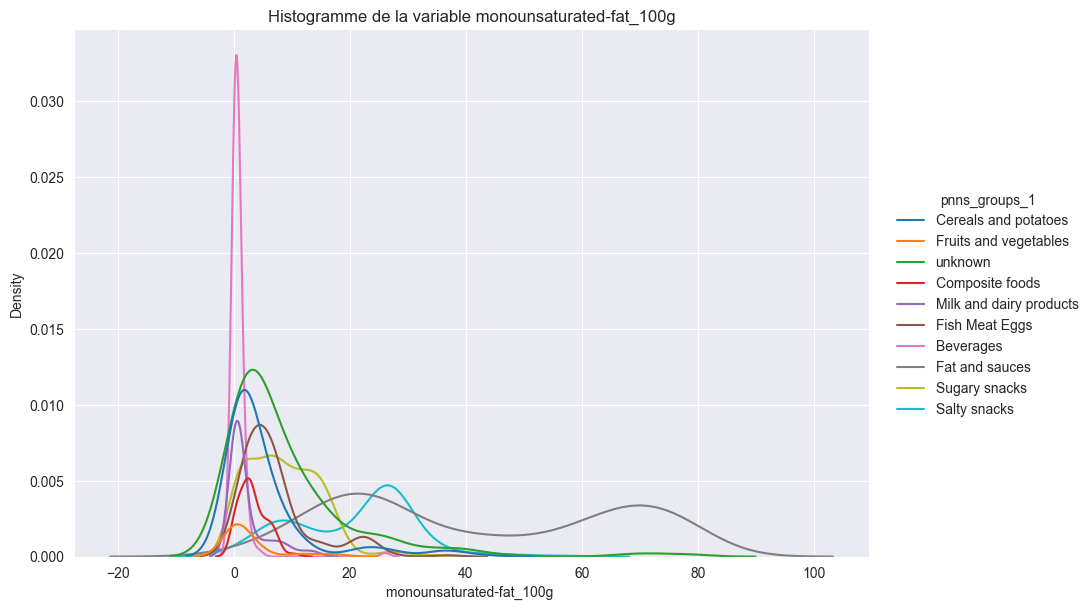

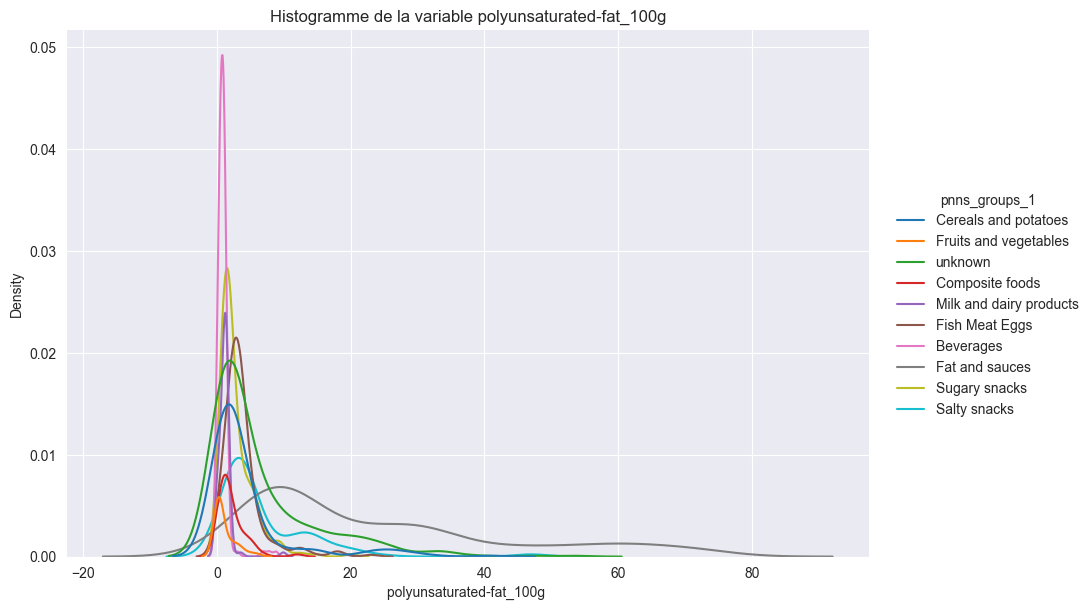

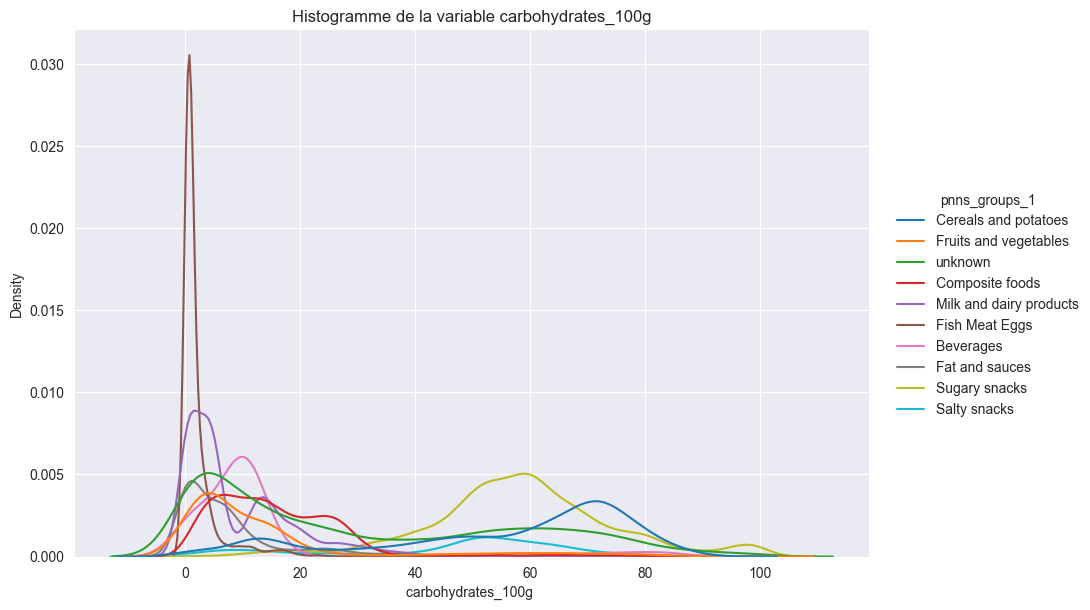

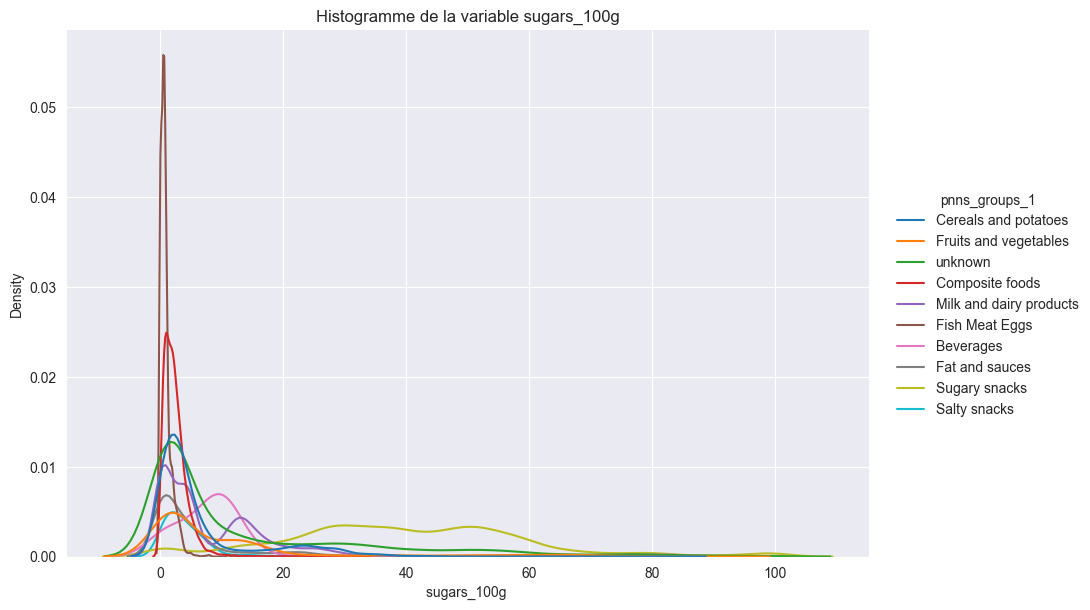

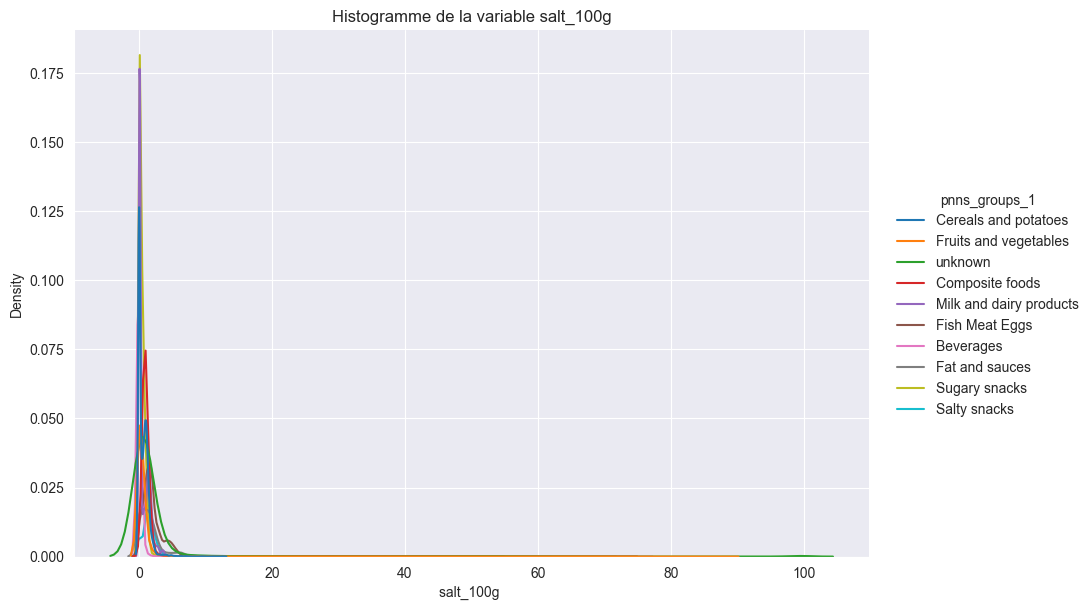

<Figure size 3000x3000 with 0 Axes>

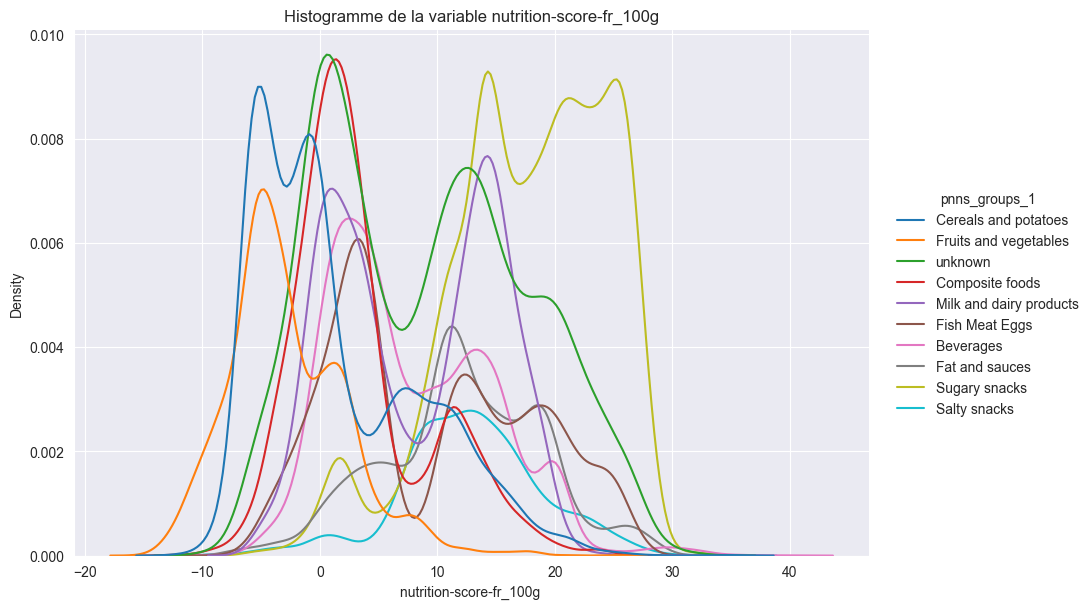

In [39]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('monounsaturated-fat_100g','forestgreen',4),('polyunsaturated-fat_100g','darkgreen',5),('carbohydrates_100g','red',6),('sugars_100g','black',7),('salt_100g','orange',8),('nutrition-score-fr_100g','purple',9)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(30, 30))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    sns.displot(data=data_clean, x=variable, hue="pnns_groups_1", kind="kde",  hue_order=hue_order,height=6, aspect=1.5) 
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


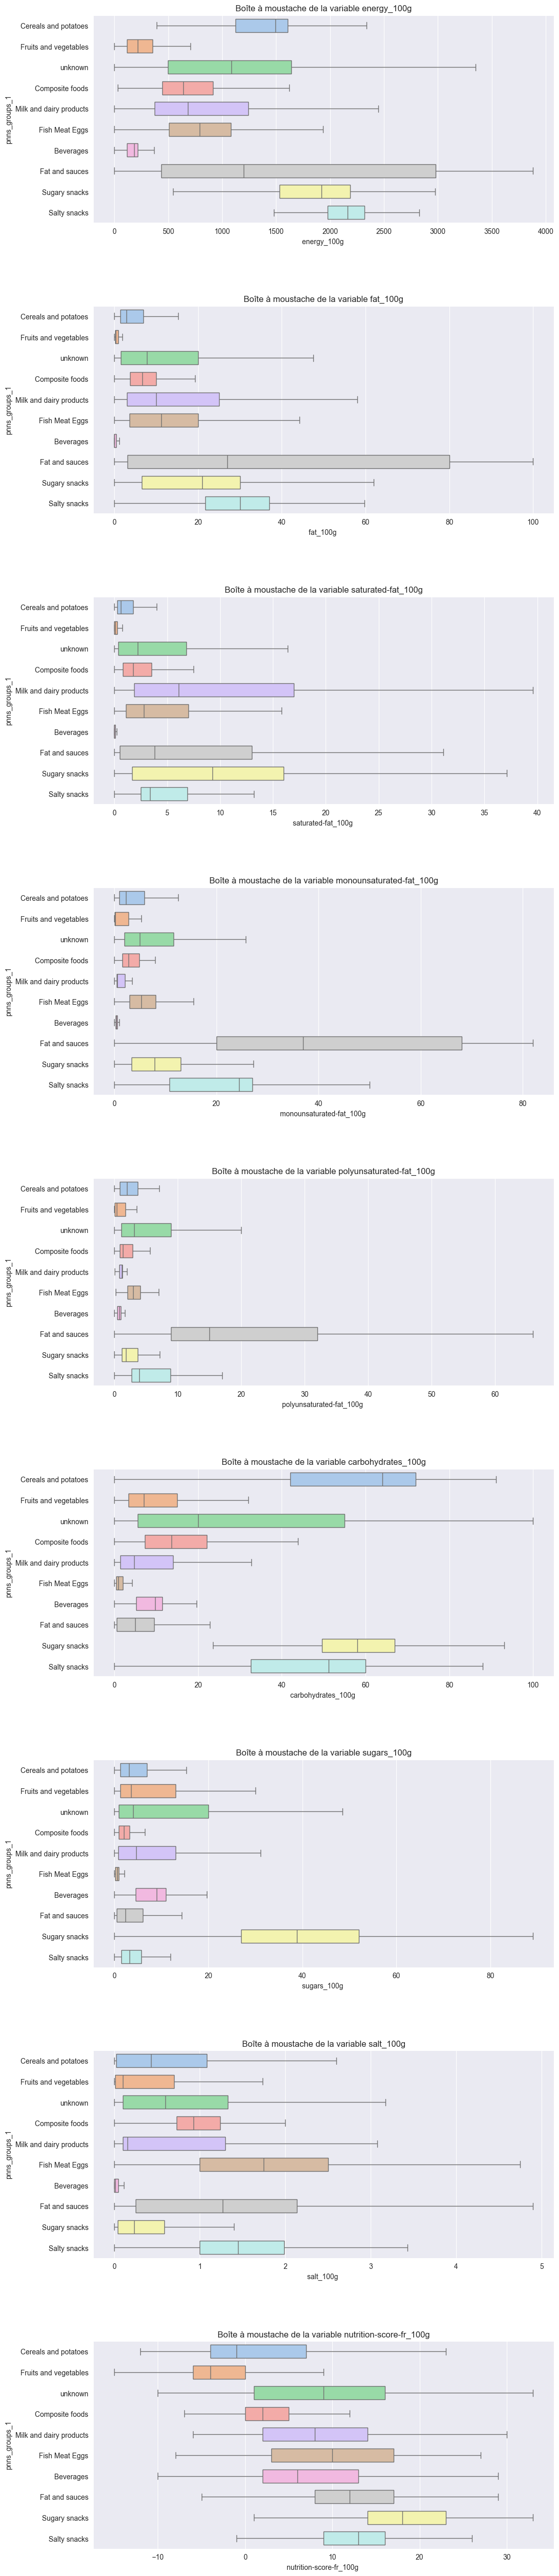

In [40]:
# Liste des variables à visualiser et leurs informations associées
variables=[('energy_100g','yellow',1),('fat_100g','blue',2),('saturated-fat_100g','green',3),('monounsaturated-fat_100g','forestgreen',4),('polyunsaturated-fat_100g','darkgreen',5),('carbohydrates_100g','red',6),('sugars_100g','black',7),('salt_100g','orange',8),('nutrition-score-fr_100g','purple',9)]
hue_order =nutriscore_order['pnns_groups_1']

# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10,10))
    plt.gcf().subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=5, hspace=0.4, wspace=0.3)

    # Création des boîtes à moustaches
    axes = figure.add_subplot(9, 1, place)
    sns.boxplot(data=data_clean,x=variable, y=data_clean["pnns_groups_1"], ax=axes, gap=0.2,legend=False,order=hue_order, showfliers=False, palette='pastel')
    plt.title(f'Boîte à moustache de la variable {variable}')
    plt.xlabel(f"{variable} ")

Comme pour les analyses univariées, on n'affichera pas les valeurs atypiques sur les boîtes à moustaches car les distributions des variables ne sont pas normales et donc la méthode interquartile n'est pas pertinente pour détecter les valeurs atypiques.

Il n'y a pas vraiment de surprises sur les résultats, on retrouve les catégories salées, sucrées et grasses avec des médianes de nutriscore les plus hauts, à l'opposé des fruits et légumes.

## Test statistique (pnns1 vs nutrition score)

### ANOVA  (qualitative vs quantitative)


On souhaite effectuer une analyse de variance pour mesurer l’indépendance entre une variable qualitative (pnns1) et une quantitative (nutriscore).

La première étape est d'analyser l'homogénéisation des variances : si elles sont égales, nous pourrons effectuer une ANOVA, sinon nous ferons une ANOVA de Welch plus pertinente dans ce cas précis.

On s'interesse au variance de chaque groupe. Le test de Levene permet de tester si les variances sont significativement différentes ou non pour des variables qui n'ont pas de distribution normale (contrairement au test de Bartlett). 


In [41]:
# Test statistique de Levene pour valider ou infirmer l'homogénéisation de la variance entre les groupes

data_levene=[data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500),
     data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500),data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500)]
test_stat, p_value = levene(data_levene[0], data_levene[1], data_levene[2], data_levene[3], data_levene[4], data_levene[5], data_levene[6], data_levene[7], data_levene[8], data_levene[9],nan_policy='omit')
print(test_stat, p_value)

175.85262544919476 1.897e-321


Les résultats du test de Levene indique qu'il n'y a pas d'homogénéité de la variance entre les groupes (p-value <0.05 donc hypothèse de l'homogénéité de la variance rejetée).

Dans ce cas, faisons une ANOVA de Welch pour compenser cette absence d'homogénéité :

In [42]:
data_welch=[]
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500))
data_welch.extend(data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500))

df = pd.DataFrame({'score': data_welch,
                   'group': np.repeat(['Beverages', 'Cereals and potatoes', 'Composite foods','Fat and sauces','Fish Meat Eggs','Fruits and vegetables','Milk and dairy products','Salty snacks',
                                      'Sugary snacks','unknown'], repeats=2500)}) 
aov = welch_anova(dv='score', between='group', data=df)
aov

Source  ddof1        ddof2            F  p-unc       np2
0  group      9  7331.603853  1878.546607    0.0  0.411973

p-value = 0 < 0.05 ce qui signifie que nous pouvons rejeter l’hypothèse nulle selon laquelle la moyenne du nutriscore est égale entre les différents groupes pnns.
Nous pouvons ensuite effectuer le test post-hoc de Games-Howell (cas de variances inégales donc d'ANOVA de Welch) pour déterminer exactement quelles moyennes de groupe sont différentes :

In [43]:
test_gh=pg.pairwise_gameshowell(dv='score', between='group', data=df)
pg.pairwise_gameshowell(dv='score', between='group', data=df)

A                        B    mean(A)    mean(B)  \
0                 Beverages     Cereals and potatoes   7.781665   1.393346   
1                 Beverages          Composite foods   7.781665   3.295357   
2                 Beverages           Fat and sauces   7.781665  12.162292   
3                 Beverages           Fish Meat Eggs   7.781665   9.561444   
4                 Beverages    Fruits and vegetables   7.781665  -2.812308   
5                 Beverages  Milk and dairy products   7.781665   8.049525   
6                 Beverages             Salty snacks   7.781665  12.792989   
7                 Beverages            Sugary snacks   7.781665  17.852867   
8                 Beverages                  unknown   7.781665   8.735123   
9      Cereals and potatoes          Composite foods   1.393346   3.295357   
10     Cereals and potatoes           Fat and sauces   1.393346  12.162292   
11     Cereals and potatoes           Fish Meat Eggs   1.393346   9.561444   
12     Cereals and potatoes    Fruits and vegetables   1.393346  -2.812308   
13     Cereals and potatoes  Milk and dairy products   1.393346   8.049525   
14     Cereals and potatoes             Salty snacks   1.393346  12.792989   
15     Cereals and potatoes            Sugary snacks   1.393346  17.852867   
16     Cereals and potatoes                  unknown   1.393346   8.735123   
17          Composite foods           Fat and sauces   3.295357  12.162292   
18          Composite foods           Fish Meat Eggs   3.295357   9.561444   
19          Composite foods    Fruits and vegetables   3.295357  -2.812308   
20          Composite foods  Milk and dairy products   3.295357   8.049525   
21          Composite foods             Salty snacks   3.295357  12.792989   
22          Composite foods            Sugary snacks   3.295357  17.852867   
23          Composite foods                  unknown   3.295357   8.735123   
24           Fat and sauces           Fish Meat Eggs  12.162292   9.561444   
25           Fat and sauces    Fruits and vegetables  12.162292  -2.812308   
26           Fat and sauces  Milk and dairy products  12.162292   8.049525   
27           Fat and sauces             Salty snacks  12.162292  12.792989   
28           Fat and sauces            Sugary snacks  12.162292  17.852867   
29           Fat and sauces                  unknown  12.162292   8.735123   
30           Fish Meat Eggs    Fruits and vegetables   9.561444  -2.812308   
31           Fish Meat Eggs  Milk and dairy products   9.561444   8.049525   
32           Fish Meat Eggs             Salty snacks   9.561444  12.792989   
33           Fish Meat Eggs            Sugary snacks   9.561444  17.852867   
34           Fish Meat Eggs                  unknown   9.561444   8.735123   
35    Fruits and vegetables  Milk and dairy products  -2.812308   8.049525   
36    Fruits and vegetables             Salty snacks  -2.812308  12.792989   
37    Fruits and vegetables            Sugary snacks  -2.812308  17.852867   
38    Fruits and vegetables                  unknown  -2.812308   8.735123   
39  Milk and dairy products             Salty snacks   8.049525  12.792989   
40  Milk and dairy products            Sugary snacks   8.049525  17.852867   
41  Milk and dairy products                  unknown   8.049525   8.735123   
42             Salty snacks            Sugary snacks  12.792989  17.852867   
43             Salty snacks                  unknown  12.792989   8.735123   
44            Sugary snacks                  unknown  17.852867   8.735123   

         diff        se           T           df          pval    hedges  
0    6.388318  0.227277   28.108077  3597.668895  0.000000e+00  0.924838  
1    4.486308  0.207118   21.660666  3232.401249  1.208367e-12  0.726457  
2   -4.380628  0.228654  -19.158336  3480.761905  0.000000e+00 -0.646036  
3   -1.779780  0.264559   -6.727342  3246.090846  9.138175e-10 -0.230646  
4   10.593972  0.206829   51.220850  3051.846232  9.846568e-13

Avec les p-values <0.05 on voit que toutes ces paires de groupe pnns ont une différence moyenne significativement différente vis à vis du nutriscore. Voici celles qui ne le sont pas :

In [45]:
test_gh_ns=test_gh.loc[test_gh['pval']>0.05]
test_gh_ns.head(45)

A                        B    mean(A)    mean(B)  \
5                 Beverages  Milk and dairy products   7.781665   8.049525   
27           Fat and sauces             Salty snacks  12.162292  12.792989   
34           Fish Meat Eggs                  unknown   9.561444   8.735123   
41  Milk and dairy products                  unknown   8.049525   8.735123   

        diff        se         T           df      pval    hedges  
5  -0.267860  0.225322 -1.188788  3545.178734  0.974172 -0.039438  
27 -0.630697  0.205014 -3.076365  3754.737185  0.065035 -0.098445  
34  0.826321  0.313419  2.636476  2917.536422  0.201063  0.095593  
41 -0.685599  0.281087 -2.439099  2471.999597  0.302916 -0.089315

Les variables "boissons" et "produits laitiers" ont donc une différence moyenne non significative vis à vis du nutriscore que ce soit entre elles ou avec le groupe "inconnu". De même pour la paire de groupes "poissons,viandes,oeufs" et "inconnu" .

Maintenant pour vérifier si les résultats de cette ANOVA de Welch peuvent être interprétables, vérifions les deux conditions essentielles : la normalité  et l'homogénéisation de la variance des résidus.

Commençons par la normalité des résidus :

In [46]:
df=data_clean.rename(columns={'nutrition-score-fr_100g': 'nutriscore'})
print(df.columns)

Index(['product_name', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_fr', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'trans-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'nutriscore'],
      dtype='object')


In [47]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'nutriscore  ~ pnns_groups_1'

model = ols(formula, data=df).fit()
res = model.resid

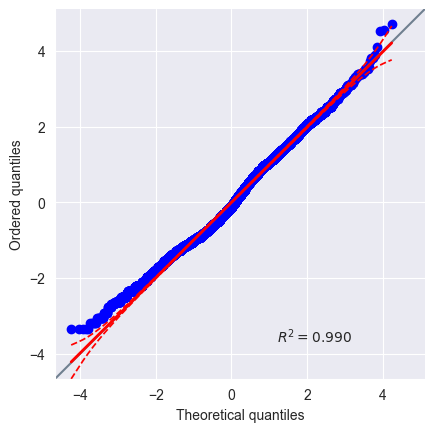

In [48]:
# QQ plot
ax = pg.qqplot(res, dist='norm')
sns.despine()

In [49]:
#Test de Shapiro-Wilk 
pg.normality(res)


W          pval  normal
0  0.99046  7.645360e-50   False

La p-value est inférieure à 0.05, l'hypothèse H0 est donc rejetée ce qui signifie que la distribution des résidus n'est pas normale. Testons maintenant l'homogénéité des variances des résidus :

In [50]:
res_groupe ={}
for groupe in df['pnns_groups_1'].unique():
    residu_gr=res[df['pnns_groups_1']==groupe]
    res_groupe[groupe]=residu_gr

In [51]:
# Test de Levene pour l'homogénéité des variances
levene_test=levene(*res_groupe.values())
print(levene_test.pvalue)

0.0


##### La p-value est inférieure à 0.05, l'hypothèse H0 est donc rejetée ce qui signifie que les variances des résidus ne sont pas homogènes.
Les deux conditions n'étant pas satisfaites, les résultats de l'ANOVA ne sont pas interprétables.

## Test de Kruskal-Wallis (comparaison de moyenne entre variable quantitative vs qualitative)

Dans ce cas nous pouvons effectuer un test non-paramètrique (c'est à dire sans condition sur la distribution des données) : le test de somme des rangs de Kruskal-Wallis.

In [52]:
data_kw=[]
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Beverages']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Cereals and potatoes']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Composite foods']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fat and sauces']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fish Meat Eggs']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Fruits and vegetables']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Milk and dairy products']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Salty snacks']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='Sugary snacks']['nutrition-score-fr_100g'].sample(2500))
data_kw.extend(data_clean[data_clean['pnns_groups_1']=='unknown']['nutrition-score-fr_100g'].sample(2500))

df = pd.DataFrame({'score': data_kw,
                   'group': np.repeat(['Beverages', 'Cereals and potatoes', 'Composite foods','Fat and sauces','Fish Meat Eggs','Fruits and vegetables','Milk and dairy products','Salty snacks',
                                      'Sugary snacks','unknown'], repeats=2500)}) 

pg.kruskal(data=df, dv='score', between='group').round(3)


Source  ddof1         H  p-unc
Kruskal  group      9  7544.791    0.0

La p-value est inférieure à 0.05, l'hypothèse H0 est donc rejetée ce qui signifie que la différence entre les moyennes des groupes est statistiquement significative.

Effectuons le test de Dunn-Bonferroni pour déterminer quelles paires diffèrent :


In [53]:
test_db=sp.posthoc_dunn(df, val_col='score',group_col='group', p_adjust = 'bonferroni')
print(test_db<0.05)

                         Beverages  Cereals and potatoes  Composite foods  \
Beverages                    False                  True             True   
Cereals and potatoes          True                 False             True   
Composite foods               True                  True            False   
Fat and sauces                True                  True             True   
Fish Meat Eggs                True                  True             True   
Fruits and vegetables         True                  True             True   
Milk and dairy products      False                  True             True   
Salty snacks                  True                  True             True   
Sugary snacks                 True                  True             True   
unknown                      False                  True             True   

                         Fat and sauces  Fish Meat Eggs  \
Beverages                          True            True   
Cereals and potatoes              

Avec les p-values <0.05 on voit les paires significativement différentes en terme de moyennes (True) et celles qui ne le sont pas (False) vis à vis du nutriscore. 

Plus précisément, voici celles qui ne diffèrent pas et ont donc une différence non significative en terme de moyenne vis à vis du nutriscore :

- la variable "boissons" n'est pas significativement différente en terme de moyenne comparé aux variables "produits laitiers" et "inconnu".
- la variable "produits laitiers" n'est pas significativement différente en terme de moyenne comparé aux variables "poissons,viandes,oeufs" et "inconnu".
- la variable "poissons,viandes,oeufs" n'est pas significativement différente en terme de moyenne comparé à la variable "inconnu".
- la variable "snacks salés" n'est pas significativement différente en terme de moyenne comparé à la variable "graisses et sauces".

On retrouve celles du test de Games-Howell après l'ANOVA de Welch avec quelques paires en plus. On peut également regarder plus en détail les paires qui ont plus de poids sur ces différences en regardant les valeurs de p-values des paires

In [54]:
print(test_db )

                             Beverages  Cereals and potatoes  Composite foods  \
Beverages                 1.000000e+00          1.677916e-62     3.521082e-28   
Cereals and potatoes      1.677916e-62          1.000000e+00     9.289957e-08   
Composite foods           3.521082e-28          9.289957e-08     1.000000e+00   
Fat and sauces            8.710802e-25         9.167250e-179    3.366536e-115   
Fish Meat Eggs            1.980173e-02          1.081643e-94     1.279577e-50   
Fruits and vegetables    1.518517e-142          3.449291e-22     3.020055e-54   
Milk and dairy products   1.000000e+00          2.542129e-79     2.623185e-38   
Salty snacks              1.116000e-35         4.106330e-217    2.763491e-144   
Sugary snacks            7.936919e-120          0.000000e+00    3.966670e-296   
unknown                   1.000000e+00          3.305318e-73     2.757966e-37   

                         Fat and sauces  Fish Meat Eggs  \
Beverages                  8.710802e-25    1.9801

## Imputation des valeurs manquantes

En terme d'inputation, commençons par supprimer la colonne 'sodium_100g' qui est identique à celle du sel, ainsi que la colonne 'trans-fat_100g' qui comporte énormément de valeurs manquantes et qui a une distribution quasi concentrée sur la valeur 0 (voir boite à moustache non logarithmique ci-dessus).

Visualisation des pourcentages de valeurs manquantes par variable conservée :

In [89]:
data_clean=data_clean.drop('sodium_100g',axis=1)
data_clean=data_clean.drop('trans-fat_100g',axis=1)
data_mv=show_miss_val(data_clean,0)
data_mv.head(20)

variable  miss_val
2              pnns_groups_1  0.000000
3              pnns_groups_2  0.000000
0               product_name  0.011105
4           main_category_fr  0.095564
5                energy_100g  0.226900
12             proteins_100g  0.234551
6                   fat_100g  0.266521
10        carbohydrates_100g  0.271691
13                 salt_100g  0.271865
11               sugars_100g  0.274844
7         saturated-fat_100g  0.278310
1         nutrition_grade_fr  0.295606
14   nutrition-score-fr_100g  0.295606
9   polyunsaturated-fat_100g  0.975298
8   monounsaturated-fat_100g  0.975576

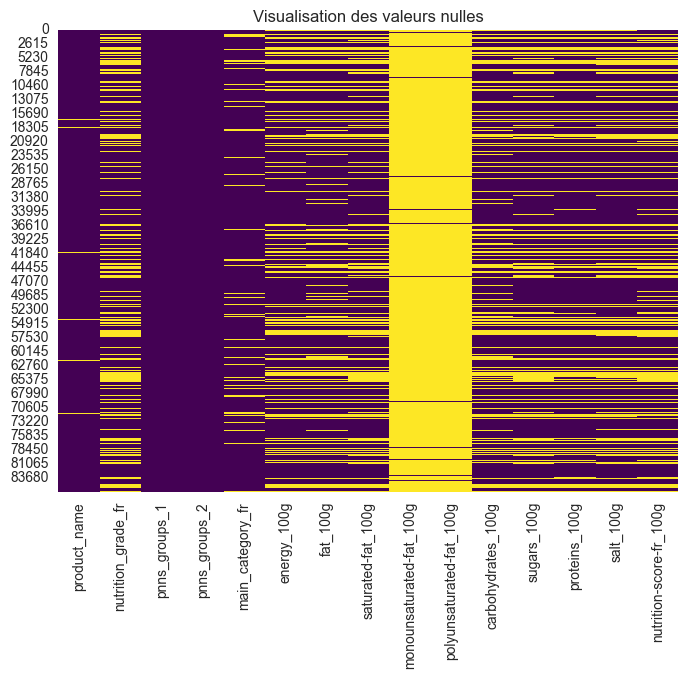

In [92]:
# Visualiser les valeurs nulles
mask = data_clean.isnull()

# Tracer le graphique
plt.figure(figsize=(8, 6))
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Visualisation des valeurs nulles')
plt.show()

### Par la médiane

Les variables "salt_100g" et "proteins_100g" ne sont pas corrélées avec d'autres variables, nous allons donc faire une imputation des valeurs manquantes par la médiane pour ces variables, en fonction de chaque groupe pnns1.

Vérifions les distributions des variables avant l'imputation afin de pouvoir les comparer avec celles d'après :

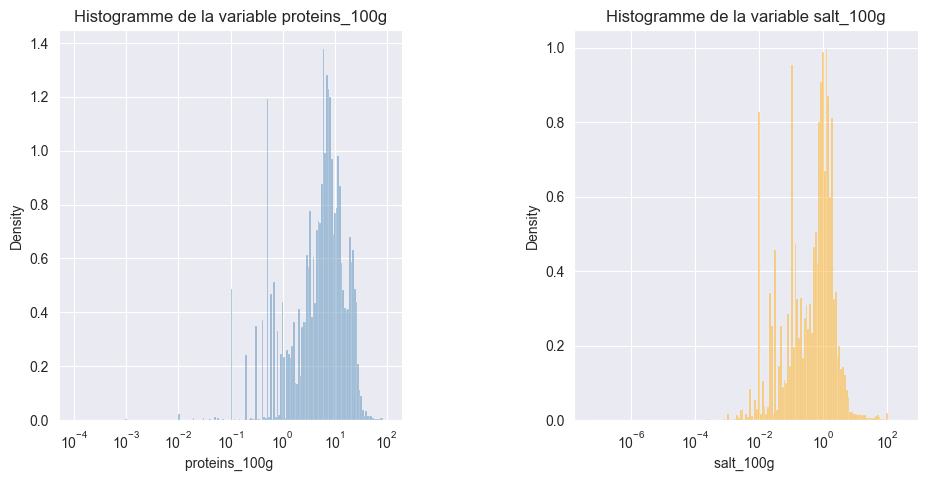

In [90]:
# Liste des variables à visualiser et leurs informations associées
variables=[('proteins_100g','steelblue',1),('salt_100g','orange',2)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


Calculons les médianes de ces deux variables par groupe pnnns1 et imputons :

In [104]:
# Imputation des variables protéines et sel par la médiane
variables=[('proteins_100g'),('salt_100g')]
for i in variables:
    data_clean[i] = data_clean[i].fillna(data_clean.groupby('pnns_groups_1')[i].transform('median'))
data_clean.head(10)

product_name nutrition_grade_fr          pnns_groups_1  \
0                   Filet de bœuf                NaN                unknown   
1                  Lion Peanut x2                  e                unknown   
2                         Twix x2                NaN                unknown   
3                  Pack de 2 Twix                NaN                unknown   
4                    Salade Cesar                  c  Fruits and vegetables   
5  Danoises à la cannelle roulées                NaN          Sugary snacks   
6                           Flute                NaN   Cereals and potatoes   
7    Chaussons tressés aux pommes                  c          Sugary snacks   
8             Pain Burger Artisan                  b                unknown   
9               lentilles vertes                 NaN   Cereals and potatoes   

        pnns_groups_2                         main_category_fr energy_100g  \
0             unknown                           Filet-de-boeuf         NaN   
1             unknown                                      NaN      1883.0   
2             unknown                                      NaN         NaN   
3             unknown                                      NaN      1481.0   
4          Vegetables                            Légumes frais      1210.0   
5  Biscuits and cakes                              Pâtisseries      1520.0   
6               Bread                                    Pains         NaN   
7  Biscuits and cakes                              Pâtisseries      1090.0   
8             unknown                                 Boulange      1160.0   
9             Legumes  Aliments et boissons à base de végétaux         NaN   

  fat_100g saturated-fat_100g monounsaturated-fat_100g  \
0      NaN                NaN                      NaN   
1     20.0               12.5                      NaN   
2      NaN                NaN                      NaN   
3     4.17                NaN                      NaN   
4     12.0                7.0                      NaN   
5     14.4                NaN                      NaN   
6      NaN                NaN                      NaN   
7     10.7                2.0                     3.33   
8     1.11              0.333                      NaN   
9      NaN                NaN                      NaN   

  polyunsaturated-fat_100g carbohydrates_100g sugars_100g  proteins_100g  \
0                      NaN                NaN         NaN           5.70   
1                      NaN               70.0        57.5           2.50   
2                      NaN                NaN         NaN           5.70   
3                      NaN              77.08         NaN           6.25   
4                      NaN               23.0         0.0          22.00   
5                      NaN               54.1        28.1           4.79   
6                      NaN                NaN         NaN           9.40   
7                     5.33               38.7        24.7           3.33   
8                      NaN               53.3        1.11          10.00   
9                      NaN                NaN         NaN           9.40   

   salt_100g nutrition-score-fr_100g  
0    0.60000                     NaN  
1    0.09652                    22.0  
2    0.60000                     NaN  
3    0.60000                     NaN  
4    2.16000                     6.0  
5    0.92200                     NaN  
6    0.43000                     NaN  
7    0.64700                     9.0  
8    1.52000                     1.0  
9    0.43000                     NaN

In [103]:
data_mv=show_miss_val(data_clean,0)
data_mv.head(20)

variable  miss_val
2              pnns_groups_1  0.000000
3              pnns_groups_2  0.000000
12             proteins_100g  0.000000
13                 salt_100g  0.000000
0               product_name  0.011105
4           main_category_fr  0.095564
5                energy_100g  0.226900
6                   fat_100g  0.266521
10        carbohydrates_100g  0.271691
11               sugars_100g  0.274844
7         saturated-fat_100g  0.278310
1         nutrition_grade_fr  0.295606
14   nutrition-score-fr_100g  0.295606
9   polyunsaturated-fat_100g  0.975298
8   monounsaturated-fat_100g  0.975576

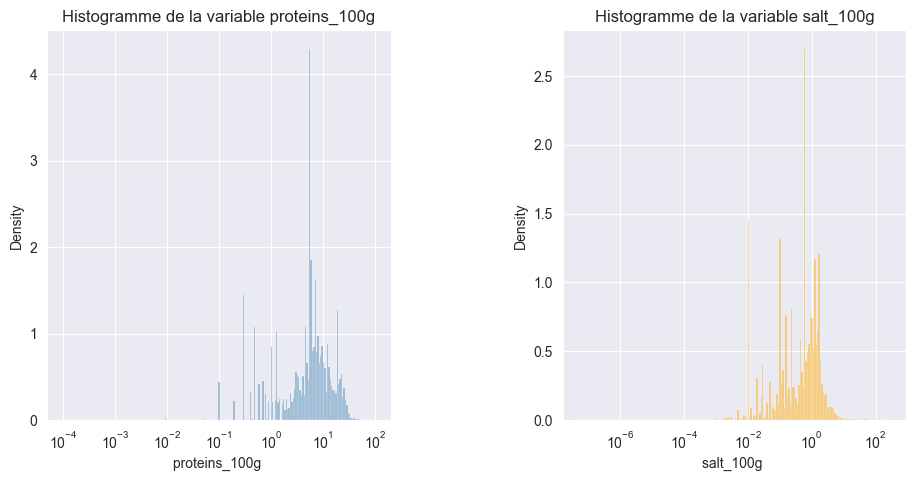

In [101]:
# Liste des variables à visualiser et leurs informations associées
variables=[('proteins_100g','steelblue',1),('salt_100g','orange',2)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

La distribution des deux variables n'a pas changé, excepté les pic de valeurs correspondant aux médianes des groupes donc l'imputation ne semble pas biaiser significativement notre base de données.

Continuons nos imputations de variables quantitatives, corrélées celles-ci, avec deux autres méthodes : l'iterative imputer et le KNN imputer.

### Par les k plus proches voisins ou KNN imputer

Méthode KNN imputer : méthode d'imputation multivariée. Pour une valeur manquante, on calcule les distance entre l'ensemble des individus et on retient les plus petites distances. Les valeurs de ces "plus proches voisins" sont alors utilisées pour imputer la valeur manquante (moyenne ou médiane des plus plroches voisins).

In [135]:
#  Création des données pour imputer
var= ['pnns_groups_1','energy_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g','polyunsaturated-fat_100g','nutrition-score-fr_100g']
del_var=[]
for v in data_clean.columns :
    if v not in var : del_var.append(v)
data_knn=data_clean.drop(del_var,axis=1)
data_knn.head()

pnns_groups_1 energy_100g fat_100g saturated-fat_100g  \
0                unknown         NaN      NaN                NaN   
1                unknown      1883.0     20.0               12.5   
2                unknown         NaN      NaN                NaN   
3                unknown      1481.0     4.17                NaN   
4  Fruits and vegetables      1210.0     12.0                7.0   

  monounsaturated-fat_100g polyunsaturated-fat_100g nutrition-score-fr_100g  
0                      NaN                      NaN                     NaN  
1                      NaN                      NaN                    22.0  
2                      NaN                      NaN                     NaN  
3                      NaN                      NaN                     NaN  
4                      NaN                      NaN                     6.0

In [136]:
# Transformation des groupes pnns1 en variable quantitatives pour le KNN imputer
cat_variables = data_knn[['pnns_groups_1']]
cat_dummies = pd.get_dummies(cat_variables, drop_first=True)
cat_dummies.head()

pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                 True                                  False   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   pnns_groups_1_unknown  
0                   True  
1                   True  
2                   True  
3                   True  
4                  False

In [137]:
data_knn = data_knn.drop(['pnns_groups_1'], axis=1)
data_knn = pd.concat([data_knn, cat_dummies], axis=1)
data_knn.head()

energy_100g fat_100g saturated-fat_100g monounsaturated-fat_100g  \
0         NaN      NaN                NaN                      NaN   
1      1883.0     20.0               12.5                      NaN   
2         NaN      NaN                NaN                      NaN   
3      1481.0     4.17                NaN                      NaN   
4      1210.0     12.0                7.0                      NaN   

  polyunsaturated-fat_100g nutrition-score-fr_100g  \
0                      NaN                     NaN   
1                      NaN                    22.0   
2                      NaN                     NaN   
3                      NaN                     NaN   
4                      NaN                     6.0   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                               False                          False   
1                               False                          False   
2                               False                          False   
3                               False                          False   
4                               False                          False   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                False                                  False   
1                                False                                  False   
2                                False                                  False   
3                                False                                  False   
4                                 True                                  False   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                       False                        False   
1                       False                        False   
2                       False                        False   
3                       False                        False   
4                       False                        False   

   pnns_groups_1_unknown  
0                   True  
1                   True  
2                   True  
3                   True  
4                  False

In [140]:
#  Scaling des données avant le KNN imputer
scaler = MinMaxScaler()
data_knn = pd.DataFrame(scaler.fit_transform(data_knn), columns = data_knn.columns)
data_knn.head()

energy_100g  fat_100g  saturated-fat_100g  monounsaturated-fat_100g  \
0          NaN       NaN                 NaN                       NaN   
1     0.000579  0.052632            0.059524                       NaN   
2          NaN       NaN                 NaN                       NaN   
3     0.000455  0.010974                 NaN                       NaN   
4     0.000372  0.031579            0.033333                       NaN   

   polyunsaturated-fat_100g  nutrition-score-fr_100g  \
0                       NaN                      NaN   
1                       NaN                 0.672727   
2                       NaN                      NaN   
3                       NaN                      NaN   
4                       NaN                 0.381818   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                 0.0                            0.0   
1                                 0.0                            0.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    0.0   
3                                  0.0                                    0.0   
4                                  1.0                                    0.0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   pnns_groups_1_unknown  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0

In [141]:
# Réalisation du KNN imputer et vérification  de la bonne imputation
imputer = KNNImputer(n_neighbors=5) #On garde les 5 plus proches voisins
data_knn = pd.DataFrame(imputer.fit_transform(data_knn),columns = data_knn.columns)
data_knn.isna().sum()


energy_100g                              0
fat_100g                                 0
saturated-fat_100g                       0
monounsaturated-fat_100g                 0
polyunsaturated-fat_100g                 0
nutrition-score-fr_100g                  0
pnns_groups_1_Cereals and potatoes       0
pnns_groups_1_Composite foods            0
pnns_groups_1_Fat and sauces             0
pnns_groups_1_Fish Meat Eggs             0
pnns_groups_1_Fruits and vegetables      0
pnns_groups_1_Milk and dairy products    0
pnns_groups_1_Salty snacks               0
pnns_groups_1_Sugary snacks              0
pnns_groups_1_unknown                    0
dtype: int64

In [142]:
data_knn.head()

energy_100g  fat_100g  saturated-fat_100g  monounsaturated-fat_100g  \
0     0.000304  0.065684            0.016848                  0.055390   
1     0.000579  0.052632            0.059524                  0.070634   
2     0.000304  0.065684            0.016848                  0.055390   
3     0.000455  0.010974            0.011419                  0.026537   
4     0.000372  0.031579            0.033333                  0.028537   

   polyunsaturated-fat_100g  nutrition-score-fr_100g  \
0                  0.046667                 0.381818   
1                  0.046560                 0.672727   
2                  0.046667                 0.381818   
3                  0.019707                 0.272727   
4                  0.008533                 0.381818   

   pnns_groups_1_Cereals and potatoes  pnns_groups_1_Composite foods  \
0                                 0.0                            0.0   
1                                 0.0                            0.0   
2                                 0.0                            0.0   
3                                 0.0                            0.0   
4                                 0.0                            0.0   

   pnns_groups_1_Fat and sauces  pnns_groups_1_Fish Meat Eggs  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   pnns_groups_1_Fruits and vegetables  pnns_groups_1_Milk and dairy products  \
0                                  0.0                                    0.0   
1                                  0.0                                    0.0   
2                                  0.0                                    0.0   
3                                  0.0                                    0.0   
4                                  1.0                                    0.0   

   pnns_groups_1_Salty snacks  pnns_groups_1_Sugary snacks  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   pnns_groups_1_unknown  
0                    1.0  
1                    1.0  
2                    1.0  
3                    1.0  
4                    0.0

### Par l'iterative imputer
Méthode qui utilise un processus itératif basé sur des modèles de régression pour prédire les valeurs manquantes en fonction des autres variables du jeu de données.

Première étape : imputation des valeurs manquantes par la moyenne ou la médiane

Deuxième étape : chaque variable avec des valeurs manquantes sont traitée comme variable cible par rapport aux autres. Un apprentissage automatique modélise les relations entre la variable cible et les autres.

Troisième étape : La modélisation de ces relations est utilisée pour prédire les valeurs manquantes à partir des autres variables.

Et on répète les deuxièmes et troisième étapes jusqu'à ce qu'il n'y ait plus de changements significatifs dans les valeurs imputées ou à partir d'un certain nombre d'itérations.

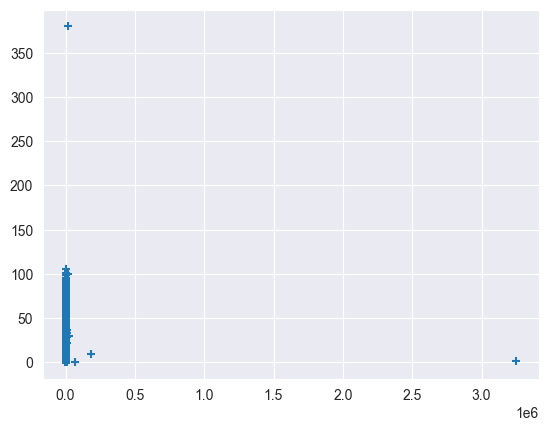

In [125]:
plt.scatter(data_imputed[:,0], data_imputed[:,1], marker='+')
plt.show()

In [130]:
var=data_clean.iloc[:,5:10]
var.head()
# il faut rajouter e nutriscore qui est corrélé aussi avec

energy_100g fat_100g saturated-fat_100g monounsaturated-fat_100g  \
0         NaN      NaN                NaN                      NaN   
1      1883.0     20.0               12.5                      NaN   
2         NaN      NaN                NaN                      NaN   
3      1481.0     4.17                NaN                      NaN   
4      1210.0     12.0                7.0                      NaN   

  polyunsaturated-fat_100g  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

In [71]:
# Imputation des données par la médiane

compt=0
for i in variables:
        for item in data_clean[i] :
            print(item.isnull())
            if item.isna()==True:
                compt+=1
print(compt)
#                 pnns= 
#                 data_clean.loc[data_clean['pnns_groups_1']==j, i]=data_temp.loc[j,i]
#             else : pass

    
#         if item=='salty-snacks' : data.loc[compt,'pnns_groups_1']= 'Salty snacks'
#         if item=='cereals-and-potatoes' : data.loc[compt,'pnns_groups_1']= 'Cereals and potatoes'
#         if item=='sugary-snacks' : data.loc[compt,'pnns_groups_1']= 'Sugary snacks'
#         if item=='fruits-and-vegetables' : data.loc[compt,'pnns_groups_1']= 'Fruits and vegetables'
#         compt+=1
#     return data

#     variables = ['energy_100g','energy-kj_100g','energy-kcal_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']
#     data_quant=col_quant(data)
#     df=data_quant.columns
#     for item in df :
#         if item =='energy_100g' :
#             data.loc[(data[item]>4000), item]= np.nan
#         elif item not in variables :
#             data.loc[(data[item]<0) |(data[item]>100), item]= np.nan
#         else : pass


# for i in variables:
#     for j in pnns1:
#         if (data_clean.loc[data_clean['pnns_groups_1']==j, i].isna()==True).item() :
#             data_clean.loc[data_clean['pnns_groups_1']==j, i]=data_temp.loc[j,i]

# Vérification de l'imputation avec affichage des valeurs manquantes
# show_miss_val(data_clean,0)

AttributeError: 'float' object has no attribute 'isnull'

In [ ]:
# Liste des variables à visualiser et leurs informations associées
variables=[('trans-fat_100g','palegreen',1),('proteins_100g','steelblue',2),('salt_100g','orange',3)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")


In [ ]:
# Liste des variables à visualiser et leurs informations associées
variables=[('trans-fat_100g','palegreen',1),('proteins_100g','steelblue',2),('salt_100g','orange',3)]
# Boucle pour générer les sous-graphiques pour chaque variable
for i, (variable,color,place) in enumerate(variables, start=1):
    # Création de la figure et réglages des paramètres
    figure=plt.figure(1, figsize=(10, 3))
    plt.gcf().subplots_adjust(left=0.125, bottom=0.2, right=1.5, top=1.5, wspace=0.5, hspace=0.5)
    
    # # Création des histogrammes
    plt.subplot(1, 3, place)
    sns.histplot(data=data_clean, x=variable, color=color,kde=True,stat="density", log_scale=True)
    plt.title(f'Histogramme de la variable {variable}')
    plt.xlabel(f"{variable} ")

La distribution de la variable trans-fat_100g n'a pas été significativement modifiée après l'imputation donc nous pouvons conserver cette imputation.

In [ ]:
dict={}
for i in range (0,10):
    dict[liste_index[i]]=liste_var[i]
print(dict)

In [ ]:
from scipy.stats import bartlett
bartlett(dict)


Sur les boites à moustaches, nous observons des valeurs atypiques pour la majorité de ces variables. 
Il semble difficile de pouvoir dire si ces valeurs atypiques sont aberrantes ou non sans être un expert et regarder chaque produit un par un.
Seules les valeurs atypiques liées au nutriscore et à l'énergie peuvent être étudiées :
- Les valeurs atypiques liées au nutriscore "e" semblent correctes car dans la méthode de calcul du nutriscore les boissons sont catégorisées "e" à partir d'un nutriscore de 10.
- Les valeurs atypiques liées au nutriscore "b" semblent correctes car dans la méthode de calcul du nutriscore les boissons sont catégorisées "b" à partir du minimum jusqu'à 2 (si ce n'est pas de l'eau).
-  Les valeurs atypiques basses liées au nutriscore "a" semblent correctes car dans la méthode de calcul du nutriscore les produits sont catégorisées "a" à partir du minimum jusqu'à atteindre les valeurs du nutriscore 'b'.
-  Les valeurs hautes liées au nutriscore 'a' sont cependant plus étonnantes car le nutriscore 'a' ne prend en compte que les valeurs égales ou inférieures à 0 et les boissons "eau".

In [ ]:
# Vérification des valeurs atypiques égales à 10 pour le nutriscore e
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']==10) & (data_clean['nutrition_grade_fr']=='e')]
x.head()

Ce sont bien des boissons donc les valeurs sont bien correctes

In [ ]:
# Vérification des valeurs atypiques les plus basses pour le nutriscore b
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']<0) & (data_clean['nutrition_grade_fr']=='b')]
x.head()

Ce sont bien des boissons donc les valeurs sont bien correctes

In [ ]:
# Vérification des valeurs atypiques les plus hautes pour le nutriscore a
x=data_clean.loc[(data_clean['nutrition-score-fr_100g']>0) & (data_clean['nutrition_grade_fr']=='a')]
x.head()

Ce sont en effet des eaux , pétillantes ou non, aromatisées ou non. Le nutriscore 'a' n'est donné qu'aux eaux, peut-être que le fait qu'elles soient pétillantes ou aromatisées n'influe pas sur le nutriscore. Nous pouvons donc penser que ces valeurs sont cohérentes.

Regardonc la répartition du nutriscore dans notre base de données :

In [ ]:
# Imputation à NaN de toutes les valeurs de nutriscore différentes de a,b,c,d ou e
nutri=['a','b','c','d','e']
data_clean.loc[~data_clean['nutrition_grade_fr'].isin(nutri)]='NaN'

In [ ]:
labels = ['NaN','A', 'B', 'C', 'D', 'E']
colors = ['#8b28c1','#36c128','#4848E1','#EDED4E','#F64D2F','#CC3B45']
sns.set_style("darkgrid")
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=labels, colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")


Il y a un nombre non négligeable de valeurs de nutrigrade manquants. Regardons si un nutriscore est renseigné afin de pouvoir l'imputer :

In [ ]:
nutriscore_mv=data_clean.loc[(data_clean['nutrition-score-fr_100g'].isna()==False) & (data_clean['nutrition_grade_fr']=='Nan')]
nutriscore_mv.shape

Aucun nutriscore n'est renseigné pour un nutrigrade manquant. L'imputation n'est donc pas évidente.

In [ ]:
data_clean.describe()

In [ ]:
data_clean.loc[(data_clean['energy_100g']>4000), 'energy_100g']= np.nan

In [ ]:
hue_order = ['a', 'b', 'c','d','e']
colors={'a' : 'green', 'b':'blue', 'c':'yellow', 'd':'orange', 'e':'red'}

figure=plt.figure(1, figsize=(20, 10))
plt.gcf().subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.5, wspace=0.5, hspace=0.1)
    
    # # Création des histogrammes
plt.subplot(1, 2, 1)
sns.histplot(data=data_clean, x='energy_100g', color='yellow',kde=True,stat="density", hue="nutrition_grade_fr", palette=colors, hue_order=hue_order)
plt.title(f'Histogramme de la variable energy_100g')
plt.xlabel(f"energy_100g ")

    # Création des boîtes à moustaches
axes = figure.add_subplot(1, 2, 2)
sns.boxplot(data=data_clean,x='energy_100g', y=data_clean["nutrition_grade_fr"], ax=axes, palette=colors,gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
plt.title(f'Boîte à moustache de la variable energy_100g')
plt.xlabel(f"energy_100g ")
plt.ylabel(f"Nutriscore")

La distribution semble plus proche de la réalité désormais. Même si des valeurs atypiques apparaissent encore sur le graphique des boites à moustaches, cela ne semble plus être des valeurs aberrantes

In [ ]:
data_clean=data_clean.drop(index=id_energy_max)
data_clean.describe()

In [ ]:
hue_order = ['a', 'b', 'c','d','e']
colors={'a' : 'green', 'b':'blue', 'c':'yellow', 'd':'orange', 'e':'red'}

figure=plt.figure(1, figsize=(20, 10))
plt.gcf().subplots_adjust(left=0.1, bottom=0.1, right=0.5, top=0.5, wspace=0.5, hspace=0.1)
    
    # # Création des histogrammes
plt.subplot(1, 2, 1)
sns.histplot(data=data_clean, x='energy_100g', color='yellow',kde=True,stat="density", hue="nutrition_grade_fr", palette=colors, hue_order=hue_order)
plt.title(f'Histogramme de la variable energy_100g')
plt.xlabel(f"energy_100g ")

    # Création des boîtes à moustaches
axes = figure.add_subplot(1, 2, 2)
sns.boxplot(data=data_clean,x='energy_100g', y=data_clean["nutrition_grade_fr"], ax=axes, palette=colors,gap=0.2,legend=False,order=["a", "b", "c", "d","e"])
plt.title(f'Boîte à moustache de la variable energy_100g')
plt.xlabel(f"energy_100g ")
plt.ylabel(f"Nutriscore")

OUTLIER de l'energie???

In [ ]:
TEST STATISTIQUES ? ANOVA ? qualitative vs quantitative avec distribution normale  ou WILCOX ??

In [ ]:
 Nous allons donc enlever ces lignes pours lesquelles nous ne pouvons pas imputer le nutrigrade qui est un élément important de notre analyse.

In [ ]:
data_clean.drop(data_clean[data_clean['nutrition_grade_fr']=='NaN'].index, inplace=True)
data_clean.shape

Il nous reste 221210 produits dans notre base de données qui sont pertinentes pour l'analyse.

In [ ]:
data_nutri =data_clean.groupby('nutrition_grade_fr')['product_name'].count()

colors = sns.color_palette('bright')[0:6]
# Affichage d'un diagramme circulaire pour visualiser la proportion des nutriscores dans notre base de données
plt.pie(x=data_nutri, labels=['a','b','c','d','e'], colors=colors,autopct='%.2f%%')
plt.title("Proportion des nutriscores")

Quasiment les 2/3 des produits de notre base de données ont un nutriscore égal à C, D ou E. Seul 1/3 ont les meilleurs nutriscores A et B.

In [ ]:
#  Fonction permettant de supprimer les 7 premières colonnes ainsi que celles ayant un pourcentage de valeurs manquantes supérieur à l'entrée percent

def del_col_prod_and_miss_val(data,percent):  
    variables = []
    miss_val = []
    del_var=[]

    # Suppression des 7 premières colonnes 
    for item in data.columns[:7] :
        del_var.append(item)
    data=data.drop(columns=del_var, axis = 1)

    # Suppression des variables avec un pourcentage de valeurs manquantes supérieur à l'entrée percent
    del_var=[]
    for item in data.columns:
        variables.append(item)
        miss_val.append(data[item].isna().mean())

    output = pd.DataFrame({
        'variable': variables, 
        'miss_val': miss_val 
    })    
        
    del_output = output[output['miss_val']>=percent]
    for item in del_output['variable'] :
        del_var.append(item)
    output_afterdrop = data.drop(columns=del_var, axis = 1)
    return output_afterdrop


In [ ]:
# Fonction permettant de remplacer les valeurs manquantes d'une colonne par une deuxième et de supprimer la deuxième colonne
def rempl_missing_value(df,col1,col2) :
    variables = [col1, col2]
    df2=df[variables].isna()
    df_missing_name=df2.loc[(df2['product_name']==True) & (df2['generic_name']==False)]
    df_missing_name_index=df_missing_name.index.to_list()
    for i in df_missing_name_index :
        df.loc[i,col1] = df.loc[i,col2]    
    return df.drop([col2], axis=1)
            

In [ ]:
# On appelle la fonction pour créer un nouveau dataframe nettoyé 
data_clean = rempl_missing_value(data,'product_name','generic_name')


En ce qui concerne les informations nutritionnelles, il parait assez logique de mettre à 0 les valeurs manquantes en considérant que si cela n'a pas été rempli c'est que la valeur est nulle.

In [ ]:
# Imputation des valeur  Nan à 0 pour les informations nutritionnelles
data.iloc[:,63]


Liste des étapes:
- suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.
- Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
- Nettoyer les données en mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
(imputation par 0, moyenne, médiane OU estimation avec ML de type KNN OU estimation via iterative imputer (pertinente que sur des variables corrélées entre elles)
- en identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
- Automatiser ces traitements pour éviter de répéter ces opérations

- Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données et de les expliquer  à un public néophyte (attention à la lisibilité : taille des textes, choix des couleurs, netteté suffisante, et variez les graphiques (boxplots, histogrammes, diagrammes circulaires, nuages de points…)).
- Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement + graphiques variables catégorielles et numériques
- Effectuer une analyse bivariée avec matrice de corrélations + graphiques croisant 2 variables numériques OU une numérique et une catégorielle
- Sélectionner / créer des variables à l’aide d’une analyse multivariée. Analyse descriptive en Composante Principale (ACP) / Analyse explicative ANOVA
Effectuer les tests statistiques appropriés pour vérifier la significativité des résultats + graphiques (ex : repartition du nutriscore, nb d'articles vendus dans chaque pays,...)

- Rédiger un rapport d’exploration et une conclusion pour expliquer la faisabilité de l’application demandée.

- Même si les données n’incluent pas de données personnelles, on doit expliquer dans une présentation en quoi ce projet respecte les 5 grands principes du RGPD. Santé publique France aimerait publier quelque chose sur le site Open Food Facts pour couper court aux questions sur le respect des RGPD que nous recevons parfois. 